In [1]:
# load some standard packages 

# if new to python will probs need to install some of these packages

import numpy as np
import xarray as xr
import math
import csv

import matplotlib.pyplot as plt
%matplotlib inline

import os
import pandas as pd

import matplotlib.gridspec as gridspec

from scipy.stats import norm
import matplotlib.pyplot as plt

# import gsw_xarray as gsw_xr # seawater calculations - might not need this one
import gsw as gsw
from geopy.distance import geodesic


/Users/isabelaconde/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Code to plot interploted data of ctd transcets; for temp, salinity and density 

- chengyuen has nutrients. on a 1dbar by 1 km interpolated grid
- this one grid 0.25 km - finer scale measurements


### Pull ctd data and plot locations 

- Some code from Megann Jeffers plot_ADCP_transects.ipynb

In [2]:
# Not neccessary to run, to check file path okay and nc file can be read - i've been having issues :/

# change to local path if running

file_path = '/Volumes/Voyages/in2024_v04/ctd/processing/in2024_v04/cap/cappro/avg/in2024_v04008CtdAvg.nc'
if os.path.exists(file_path):
    try:
        with open(file_path, 'rb') as f:
            f.read(100)  # Read the first 100 bytes
        print(f"File {file_path} is accessible.")
    except Exception as e:
        print(f"Failed to read {file_path}: {e}")
else:
    print(f"File {file_path} does not exist.")

File /Volumes/Voyages/in2024_v04/ctd/processing/in2024_v04/cap/cappro/avg/in2024_v04008CtdAvg.nc does not exist.


In [2]:
# read_nc_file function adapted from megan's code
def read_nc_file(file):

    # ds = xr.open_dataset(file)
    ds=xr.open_dataset(file, engine='netcdf4')

    # Extract the variables
    pressure = ds['pressure'].values
    temperature = ds['temperature'].values
    salinity = ds['salinity'].values
    oxygen = ds['oxygen'].values
    latitude = ds['latitude'].values[0]
    longitude = ds['longitude'].values[0]
    time = ds['time'].values[0]

    pressure_reshaped = np.reshape(pressure, (1, 1, len(pressure), 1))

    # calculate absolute salinity
    SA = gsw.SA_from_SP(salinity, pressure_reshaped, longitude, latitude)
    # calculate conservative temperature 
    CT = gsw.CT_from_t(SA, temperature, pressure_reshaped)
    # calulate density 
    density = gsw.density.rho(SA,CT,pressure_reshaped)
    # Calculate depth
    depth = gsw.z_from_p(pressure, latitude)
    # Create an xarray DataArray with explicit dimension names
    density_da = xr.DataArray(
        density,
        dims=['longitude','latitude','pressure','time'],
        coords={'longitude': longitude,
                'latitude': latitude,
                'pressure': pressure,
                'time': time}
    )
    pressure_da = xr.DataArray(
        pressure,
        dims=['depth'],
        coords={'depth': depth}
    )
    # Create a new xarray dataset with explicit dimension names
        # Create the dataset
    new_ds = xr.Dataset(
        {
            'temperature': (('longitude', 'latitude', 'depth', 'time'), temperature),
            'salinity': (('longitude', 'latitude', 'depth', 'time'), salinity),
            'oxygen': (('longitude', 'latitude', 'depth', 'time'), oxygen),
            'density': (('longitude', 'latitude', 'depth', 'time'), density_da.data),
            'pressure': (pressure_da.dims, pressure_da.data)
        },
        coords={
            'longitude': ('longitude', [longitude]),
            'latitude': ('latitude', [latitude]),
            'depth': ('depth', depth),
            'time': ('time', [time]),
        }
    )
    return new_ds

data_list = []
def open_nc_files(folder_path):
    # List all files in the folder
    files = os.listdir(folder_path)
    
    # Filter out only .nc files
    nc_files = [file for file in files if file.endswith('.nc')]
    
    # Open and process each .nc file
    for nc_file in nc_files:
        file_path = os.path.join(folder_path, nc_file)

        # Extract the numeric part '046' from the filename
        numeric_part = ''.join(filter(str.isdigit, nc_file))[-3:]
        
        # Create the variable name
        variable_name = f"ctd_{numeric_part}"
        try:
            dataset = read_nc_file(file_path)
            # print('file read')
            # Assign the dataset to the variable name in the global scope
            globals()[variable_name] = dataset

            latitude = dataset['latitude'].values[0]
            longitude = dataset['longitude'].values[0]

            data_list.append({
                'ctd': variable_name,
                'latitude': latitude,
                'longitude': longitude
            })

        except Exception as e:
            print(f"Failed to open {nc_file}: {e}")
    df = pd.DataFrame(data_list)
    df.to_csv('/Users/isabelaconde/Desktop/ctd_coordinates.csv', index=False)

# Specify the folder containing .nc files
folder_path = '/Users/isabelaconde/Desktop/avg'


open_nc_files(folder_path)

# load the ctd_ops dataset
variable_names = [var_name for var_name in globals() if var_name.startswith('ctd_')] # run before loading ctd_ops dataset

In [3]:

file_path = '/Users/isabelaconde/Desktop/ctd_file_mapping.xlsx'

# deep tow camera lines for solitary 
dtc_sol = pd.read_csv('/Users/isabelaconde/Desktop/sol_lines.csv')
# deep tow camera lines for richmond
dtc_rich = pd.read_csv('/Users/isabelaconde/Desktop/richmond_dtc_2406.csv')

# Microrider xcel file which listed ctd and dat numbers
#Read only columns C and F from the Excel file
df = pd.read_excel(file_path, sheet_name='Sheet1')
# ctd ops for microrider dat files
ctd_ops = []
for i in range(len(df['File name'])):
    if pd.notna(df['File name'][i]):
        ctd_ops.append(df['ctd num'][i])


In [6]:
# load bathymetry data
sol_b = xr.open_dataset('/Users/isabelaconde/Desktop/Solitary_Island_Canyon_High_Res_Bathy.nc')
rich_b = xr.open_dataset('/Users/isabelaconde/Desktop/RichmondCanyon_50m.nc')

# Plot of operations in each canyon 

Read off map for transects


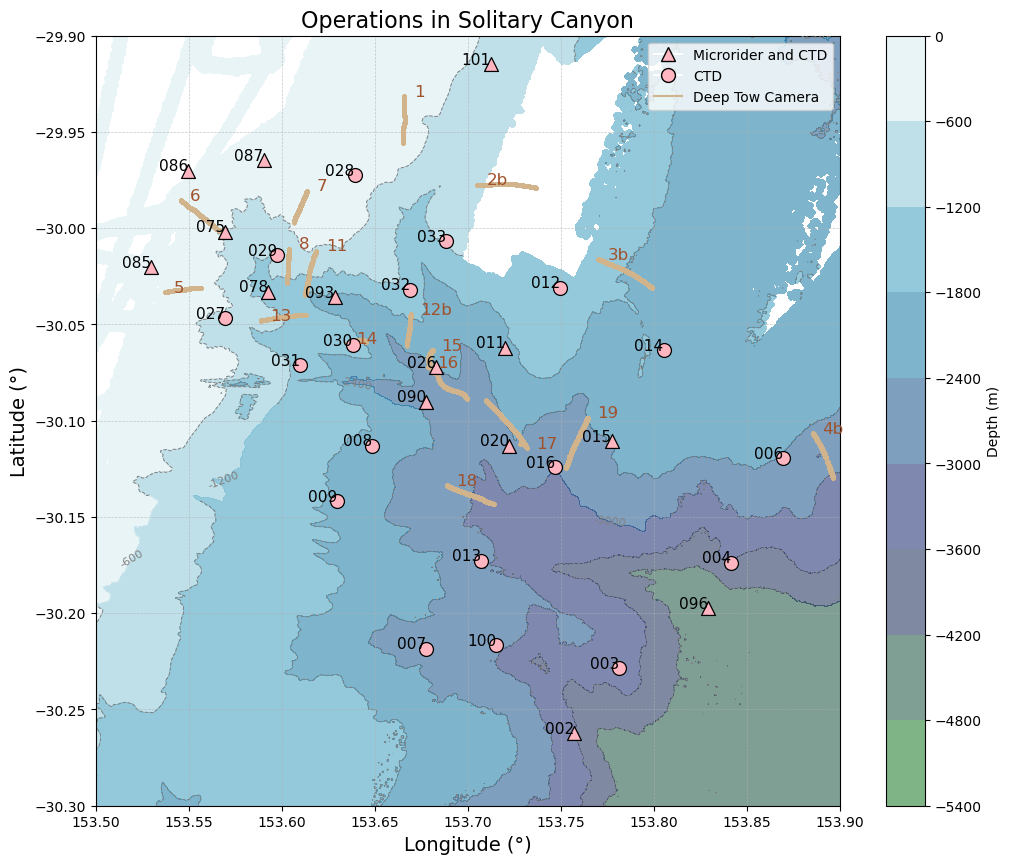

In [7]:
latitudes = []
longitudes = []

bathy = sol_b

# Extract coordinates from each dataset
for var_name in variable_names:
    dataset = globals()[var_name]
    latitudes.append(dataset['latitude'].values[0])
    longitudes.append(dataset['longitude'].values[0])

# Define tolerance for considering points as duplicates
tolerance = 1e-2

# Function to filter out points that are within the given tolerance
def filter_duplicate_points(lons, lats, names, tol):
    unique_lons = []
    unique_lats = []
    unique_names = []
    
    for lon, lat, name in zip(lons, lats, names):
        if all(np.sqrt((lon - ulon)**2 + (lat - ulat)**2) > tol for ulon, ulat in zip(unique_lons, unique_lats)):
            unique_lons.append(lon)
            unique_lats.append(lat)
            unique_names.append(name)
    
    return unique_lons, unique_lats, unique_names

# Filter points
filtered_longitudes, filtered_latitudes, filtered_variable_names = filter_duplicate_points(longitudes, latitudes, variable_names, tolerance)

# Load bathymetry data
bathy_data = bathy.Band1

# Create a meshgrid for the contour plot
lon_bathy, lat_bathy = np.meshgrid(bathy.lon, bathy.lat)

# Define the list of variable names to be plotted with a red outline

# Plotting function with enhanced visuals
def plot_with_contours(ax, longitudes, latitudes, variable_names, lon_bathy, lat_bathy, bathy_data):
    for i, (lon, lat, var_name) in enumerate(zip(longitudes, latitudes, variable_names)):
        marker = '^' if var_name in ctd_ops else 'o'
        sc = ax.scatter(lon, lat, c='#ffb6c1', s=100, edgecolor='k', linewidth=0.9, zorder=5,marker=marker)
        ax.annotate(var_name[-3:], (lon, lat), fontsize=11, ha='right', color='k', zorder=6)
    
    # Add contour lines
    contour = ax.contour(lon_bathy, lat_bathy, bathy_data, colors='grey', linewidths=0.7, zorder=1)
    ax.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

    ax.set_title('Operations in Solitary Canyon', fontsize=16)
    ax.set_xlabel('Longitude (°)', fontsize=14)
    ax.set_ylabel('Latitude (°)', fontsize=14)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Adding a color bar to show depth variation
    contour_filled = ax.contourf(lon_bathy, lat_bathy, bathy_data, cmap='ocean', alpha=0.5, zorder=0)
    fig.colorbar(contour_filled, ax=ax, orientation='vertical', label='Depth (m)')

# Function to plot camera tow lines
def plot_camera_tow_lines(ax, dtc_sol):
    grouped = dtc_sol.groupby('Line_no')
    for name, group in grouped:
        ax.plot(group['longitude'], group['latitude'], linestyle='-', marker='o', color='tan', markersize=2, linewidth=1, label=f'Tow Line {name}')
        ax.annotate(str(name), (group['longitude'].values[0]  + 0.005, group['latitude'].values[0]), fontsize=12, ha='left', color='sienna', zorder=6)


# Plot showing Solitary Canyon
fig, ax = plt.subplots(figsize=(12, 10))
plot_with_contours(ax, filtered_longitudes, filtered_latitudes, filtered_variable_names, lon_bathy, lat_bathy, bathy_data)

# Plot camera tow lines
plot_camera_tow_lines(ax, dtc_sol)

# Create legend elements
ctd_microrider = plt.Line2D([0], [0], marker='^', color='w', label='Microrider and CTD', markerfacecolor='#ffb6c1', markeredgecolor='k', markersize=10)
ctd_only = plt.Line2D([0], [0], marker='o', color='w', label='CTD', markerfacecolor='#ffb6c1', markeredgecolor='k', markersize=10)
camera_tow = plt.Line2D([0], [0], linestyle='-', color='tan', label='Deep Tow Camera')

# Add the legend to the plot
ax.legend(handles=[ctd_microrider, ctd_only, camera_tow], loc='upper right')

ax.set_ylim([-30.3, -29.9])
ax.set_xlim([153.5, 153.9])

plt.show()


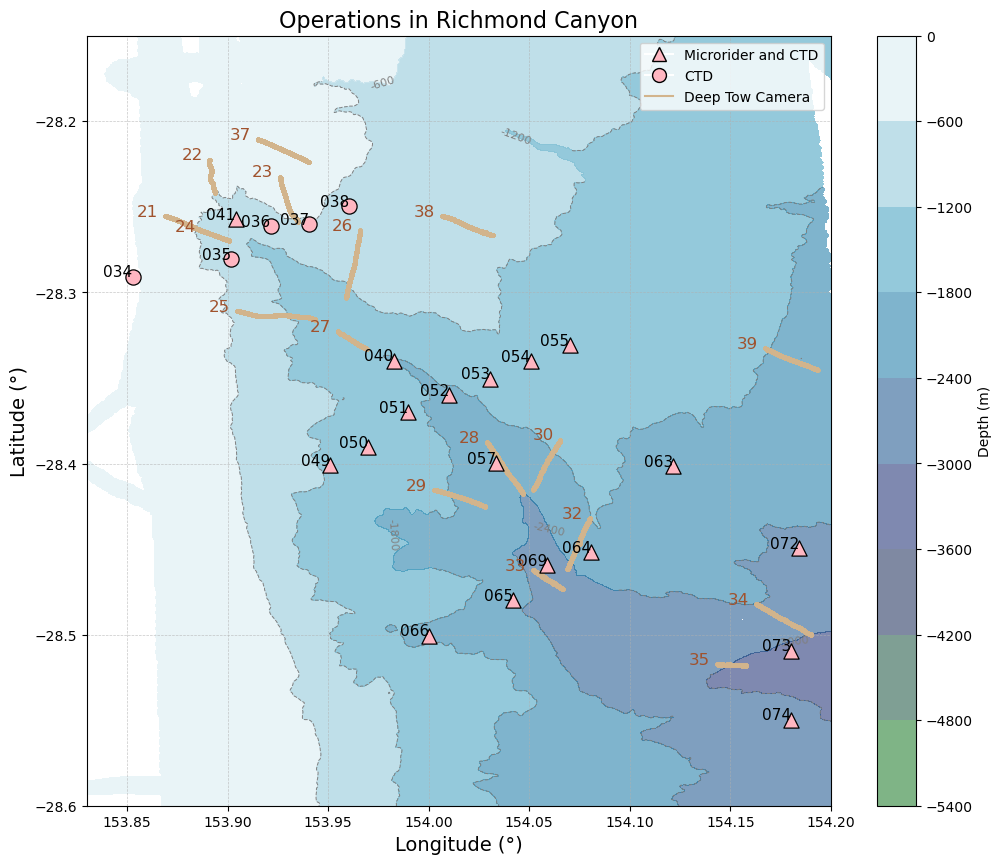

In [8]:

latitudes = []
longitudes = []

bathy = rich_b

# Collect relevant variable names
# variable_names = [var_name for var_name in globals() if var_name.startswith('ctd_')]

# Extract coordinates from each dataset
for var_name in variable_names:
    dataset = globals()[var_name]
    latitudes.append(dataset['latitude'].values[0])
    longitudes.append(dataset['longitude'].values[0])

# Load the dataset for camera tow lines (replace with your actual file path)
# dtc_sol = pd.read_csv('path_to_your_dtc_sol_csv_file.csv')

# Define tolerance for considering points as duplicates
tolerance = 1e-2

# Function to filter out points that are within the given tolerance
def filter_duplicate_points(lons, lats, names, tol):
    unique_lons = []
    unique_lats = []
    unique_names = []
    
    for lon, lat, name in zip(lons, lats, names):
        if all(np.sqrt((lon - ulon)**2 + (lat - ulat)**2) > tol for ulon, ulat in zip(unique_lons, unique_lats)):
            unique_lons.append(lon)
            unique_lats.append(lat)
            unique_names.append(name)
    
    return unique_lons, unique_lats, unique_names

# Filter points
filtered_longitudes, filtered_latitudes, filtered_variable_names = filter_duplicate_points(longitudes, latitudes, variable_names, tolerance)

# Load bathymetry data
bathy_data = bathy.Band1

# Create a meshgrid for the contour plot
lon_bathy, lat_bathy = np.meshgrid(bathy.lon, bathy.lat)

# Define the list of variable names to be plotted with a red outline

# Plotting function with enhanced visuals
def plot_with_contours(ax, longitudes, latitudes, variable_names, lon_bathy, lat_bathy, bathy_data):
    for i, (lon, lat, var_name) in enumerate(zip(longitudes, latitudes, variable_names)):
        marker = '^' if var_name in ctd_ops else 'o'
        sc = ax.scatter(lon, lat, c='#ffb6c1', s=120, edgecolor='k', linewidth=0.9, zorder=5, marker=marker)
        ax.annotate(var_name[-3:], (lon, lat), fontsize=11, ha='right', color='k', zorder=6)
    
    # Add contour lines
    contour = ax.contour(lon_bathy, lat_bathy, bathy_data, colors='grey', linewidths=0.7, zorder=1)
    ax.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

    ax.set_title('Operations in Richmond Canyon', fontsize=16)
    ax.set_xlabel('Longitude (°)', fontsize=14)
    ax.set_ylabel('Latitude (°)', fontsize=14)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Adding a color bar to show depth variation
    contour_filled = ax.contourf(lon_bathy, lat_bathy, bathy_data, cmap='ocean', alpha=0.5, zorder=0)
    fig.colorbar(contour_filled, ax=ax, orientation='vertical', label='Depth (m)')

# Function to plot camera tow lines
def plot_camera_tow_lines(ax, dtc_rich):
    grouped = dtc_rich.groupby('Line_no')
    for name, group in grouped:
        ax.plot(group['longitude'], group['latitude'], linestyle='-', marker='o', color='tan', markersize=2, linewidth=1, label=f'Tow Line {name}')
        ax.annotate(str(name), (group['longitude'].values[0]  - 0.014, group['latitude'].values[0]), fontsize=12, ha='left', color='sienna', zorder=6)


# Plot showing Solitary Canyon
fig, ax = plt.subplots(figsize=(12, 10))

# Plot CTD points and bathymetry
plot_with_contours(ax, filtered_longitudes, filtered_latitudes, filtered_variable_names, lon_bathy, lat_bathy, bathy_data)

# Plot camera tow lines
plot_camera_tow_lines(ax, dtc_rich)


# Create legend elements
ctd_microrider = plt.Line2D([0], [0], marker='^', color='w', label='Microrider and CTD', markerfacecolor='#ffb6c1', markeredgecolor='k', markersize=10)
ctd_only = plt.Line2D([0], [0], marker='o', color='w', label='CTD', markerfacecolor='#ffb6c1', markeredgecolor='k', markersize=10)
camera_tow = plt.Line2D([0], [0], linestyle='-', color='tan', label='Deep Tow Camera')

# Add the legend to the plot
ax.legend(handles=[ctd_microrider, ctd_only, camera_tow], loc='upper right')

# Adjust plot limits
ax.set_ylim([ -28.6,-28.15])
ax.set_xlim([153.83, 154.2])

# Add legend for camera tow lines
# ax.legend(loc='upper right')

plt.show()



read off maps for transects

In [10]:
# define transects from map above

# transects for solitarry canyon 
transect1 = [ctd_002, ctd_003, ctd_004, ctd_006]
transect2 = [ctd_007, ctd_013, ctd_016, ctd_015, ctd_014]
transect3 = [ctd_009, ctd_008, ctd_026, ctd_011, ctd_012]
transect4 = [ctd_031,ctd_030, ctd_032, ctd_033]
transect5 = [ctd_027, ctd_076, ctd_029, ctd_028]
transect6 = [ctd_085, ctd_086, ctd_087]

In [11]:
# transects from richmond canyon
Rtransect1 = [ctd_074,ctd_073,ctd_072]
Rtransect2 = [ctd_066,ctd_065,ctd_069,ctd_064,ctd_063]
Rtransect3 = [ctd_049,ctd_050,ctd_051,ctd_052,ctd_053,ctd_054,ctd_055]
Rtransect4 = [ctd_034,ctd_035,ctd_036,ctd_037,ctd_038]


## interpolate to get transects


In [12]:
# Megan's function to calculate distance between casts

def calculate_distances(casts):
    base_coord = (casts[0]['latitude'], casts[0]['longitude'])
    distances = [0]  # Distance from the first included cast is 0
    for cast in casts[1:]:
        coord = (cast['latitude'], cast['longitude'])
        distance = geodesic(base_coord, coord).kilometers
        distances.append(distance)
    return distances



In [13]:
def datasets_transects(transect):

    dist = calculate_distances(transect) 

    # Find the maximum depth across all transects using list comprehension
    max_depth = 4000
    # print(str(transect)+'okay')
    new_depth = -np.arange(0,max_depth, 1)

    # initialise empty arrays to store interpolated data
    temp_array = np.full((len(new_depth),len(transect)), np.nan)
    pressure_array = np.full((len(new_depth),len(transect)), np.nan)
    salinity_array = np.full((len(new_depth),len(transect)), np.nan)
    oxygen_array = np.full((len(new_depth),len(transect)), np.nan)
    density_array = np.full((len(new_depth),len(transect)), np.nan)



    for i in range(len(transect)):
        # print(transect[i]['temperature'])
        # print(da_pressure)

        old_depth= transect[i]['temperature'].drop_vars('time').drop_vars('longitude').drop_vars('latitude').depth.values


        temp = xr.DataArray(transect[i]['temperature'].squeeze(['time','latitude','longitude']).drop_vars(['time','longitude','latitude']), coords={'depth': old_depth})
        pressure = xr.DataArray(transect[i]['pressure'],  coords={'depth': old_depth})
        salinity = xr.DataArray(transect[i]['salinity'].squeeze(['time','latitude','longitude']).drop_vars(['time','longitude','latitude']), coords={'depth': old_depth})
        oxygen = xr.DataArray(transect[i]['oxygen'].squeeze(['time','latitude','longitude']).drop_vars(['time','longitude','latitude']), coords={'depth': old_depth})
        density = xr.DataArray(transect[i]['density'].squeeze(['time','latitude','longitude']).drop_vars(['time','longitude','latitude']), coords={'depth': old_depth})


        
        # # interpolate on to a constant grid 
        da_temp= temp.interp(depth = new_depth, method='linear')
        da_pressure = pressure.interp(depth = new_depth, method='linear')#.drop_vars('time')
        da_salinty = salinity.interp(depth = new_depth, method='linear')
        da_oxygen = oxygen.interp(depth = new_depth, method='linear')
        da_density = density.interp(depth = new_depth, method='linear')




    #     # temperature_values = transect1[i]['temperature'].values.flatten()  # Ensure 1D array
    #     # length = len(temperature_values)
        temp_array[:, i] = da_temp.values
        pressure_array[:, i] = da_pressure.values
        salinity_array[:, i] = da_salinty.values
        oxygen_array[:, i] = da_oxygen.values
        density_array[:, i] = da_density.values


    temp_array = xr.DataArray(temp_array, dims=['depth', 'distance'], coords={'depth': new_depth, 'distance': np.array(dist)})
    pressure_array = xr.DataArray(pressure_array, dims=['depth', 'distance'], coords={'depth': new_depth, 'distance': np.array(dist)})
    salinity_array = xr.DataArray(salinity_array, dims=['depth', 'distance'], coords={'depth': new_depth, 'distance': np.array(dist)})
    oxygen_array = xr.DataArray(oxygen_array, dims=['depth', 'distance'], coords={'depth': new_depth, 'distance': np.array(dist)})
    density_array = xr.DataArray(density_array, dims=['depth', 'distance'], coords={'depth': new_depth, 'distance': np.array(dist)})

    temp_transect= temp_array.interp(distance = np.arange(0,max(dist), 1), method='linear')
    pressure_transect= pressure_array.interp(distance = np.arange(0,max(dist), 1), method='linear')
    oxygen_transect= oxygen_array.interp(distance = np.arange(0,max(dist), 1), method='linear')
    salinity_transect= salinity_array.interp(distance = np.arange(0,max(dist), 1), method='linear')
    density_transect= density_array.interp(distance = np.arange(0,max(dist), 1), method='linear')

    # #Create a new xarray dataset with explicit dimension names
    transect_ds = xr.Dataset(
        {
            'temperature': (temp_transect.dims, temp_transect.data),
            'salinity': (salinity_transect.dims, salinity_transect.data),
            'oxygen': (oxygen_transect.dims, oxygen_transect.data),
            'density': (density_transect.dims, density_transect.data),
            'pressure': (pressure_transect.dims, pressure_transect.data)
        },
        coords={
            'depth': (temp_transect['depth'].dims, temp_transect.depth.values),
            'distance': (temp_transect['distance'].dims, temp_transect.distance.values)
        }
    )


    return transect_ds


In [14]:
# run function to get xarray datset transects
datasets_transect1 = datasets_transects(transect1)
datasets_transect2 = datasets_transects(transect2)
datasets_transect3 = datasets_transects(transect3)
datasets_transect4 = datasets_transects(transect4)
datasets_transect5 = datasets_transects(transect5)
datasets_transect6 = datasets_transects(transect6)


# also find transect for thalweg
# array of which ctds
dt_thalweg_sol=[ctd_086,ctd_075,ctd_029,ctd_093,ctd_030,ctd_026,ctd_020,ctd_016,ctd_096]
dt_thalweg_rich=[ctd_041,ctd_040,ctd_052,ctd_057,ctd_064,ctd_074]

# interpolated transects
thalweg_sol = datasets_transects([ctd_086,ctd_075,ctd_029,ctd_093,ctd_030,ctd_026,ctd_020,ctd_016,ctd_096])
thalweg_rich = datasets_transects([ctd_041,ctd_040,ctd_052,ctd_057,ctd_064,ctd_074])


In [17]:
def plot_interp_profiles(datasets_transects,dt, bathy_data):

    # if not plotting bathy just have dt and bathy_data as 0

        
    # Assuming datasets_transect1 is a dictionary with 'distance', 'depth', and the variables as keys
    distance = datasets_transects['distance'].values
    depth = datasets_transects['depth'].values
    variables = ['temperature', 'salinity', 'oxygen', 'density']
    titles = ['Temperature', 'Salinity', 'Oxygen', 'Density']
    colormaps = ['viridis', 'plasma', 'inferno', 'PuBuGn']

    max_depth = min(datasets_transects['depth'].values)

    # Create a meshgrid for the pcolormesh
    X, Y = np.meshgrid(distance, depth)

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    for i, ax in enumerate(axes.flat):
        var = datasets_transects[variables[i]].values
        pcm = ax.pcolormesh(X, Y, var, shading='auto', cmap=colormaps[i])
        # pcm = ax.contourf(X, Y, var, cmap=colormaps[i], levels=10)

        
        # Adding a color bar
        cbar = fig.colorbar(pcm, ax=ax, orientation='vertical')
        cbar.set_label(titles[i], rotation=270, labelpad=15)

        # Adding labels and title
        ax.set_xlabel('Distance (km)', fontsize=12)
        ax.set_ylabel('Depth (m)', fontsize=12)
        ax.set_title(f'CTD Transect {titles[i]} Plot', fontsize=15)

        # Customizing the axes
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensuring x-axis labels are integers
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.set_ylim([max_depth, 0])  # Invert y-axis to have depth increasing downwards

        # Adding grid for better readability
        ax.grid(True, linestyle='--', alpha=0.6)

        # Check if bathymetry values are non-zero
        if np.any(bathy_data != 0):
            start_lat, start_lon = dt[0].latitude.values[0], dt[0].longitude.values[0]  # Replace with your actual start point
            end_lat, end_lon = dt[len(dt)-1].latitude.values[0], dt[len(dt)-1].longitude.values[0]     # Replace with your actual end point
            num_points = 100  # Number of points along the transect
            lats = np.linspace(start_lat, end_lat, num_points)
            lons = np.linspace(start_lon, end_lon, num_points)
            transect_data = bathy_data.interp(lat=xr.DataArray(lats, dims="points"), lon=xr.DataArray(lons, dims="points"))

                    # Create a twin axis for the distance
            ax2 = ax.twiny()
            ax2.plot(transect_data['lon'], transect_data['Band1'], label='Transect Data')
            # Set the limits of the x-axes to be the same
            ax2.set_xlim(start_lon, end_lon)
            ax2.set_ylim(transect_data['Band1'].min(),0)




    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


### Solitary Canyon

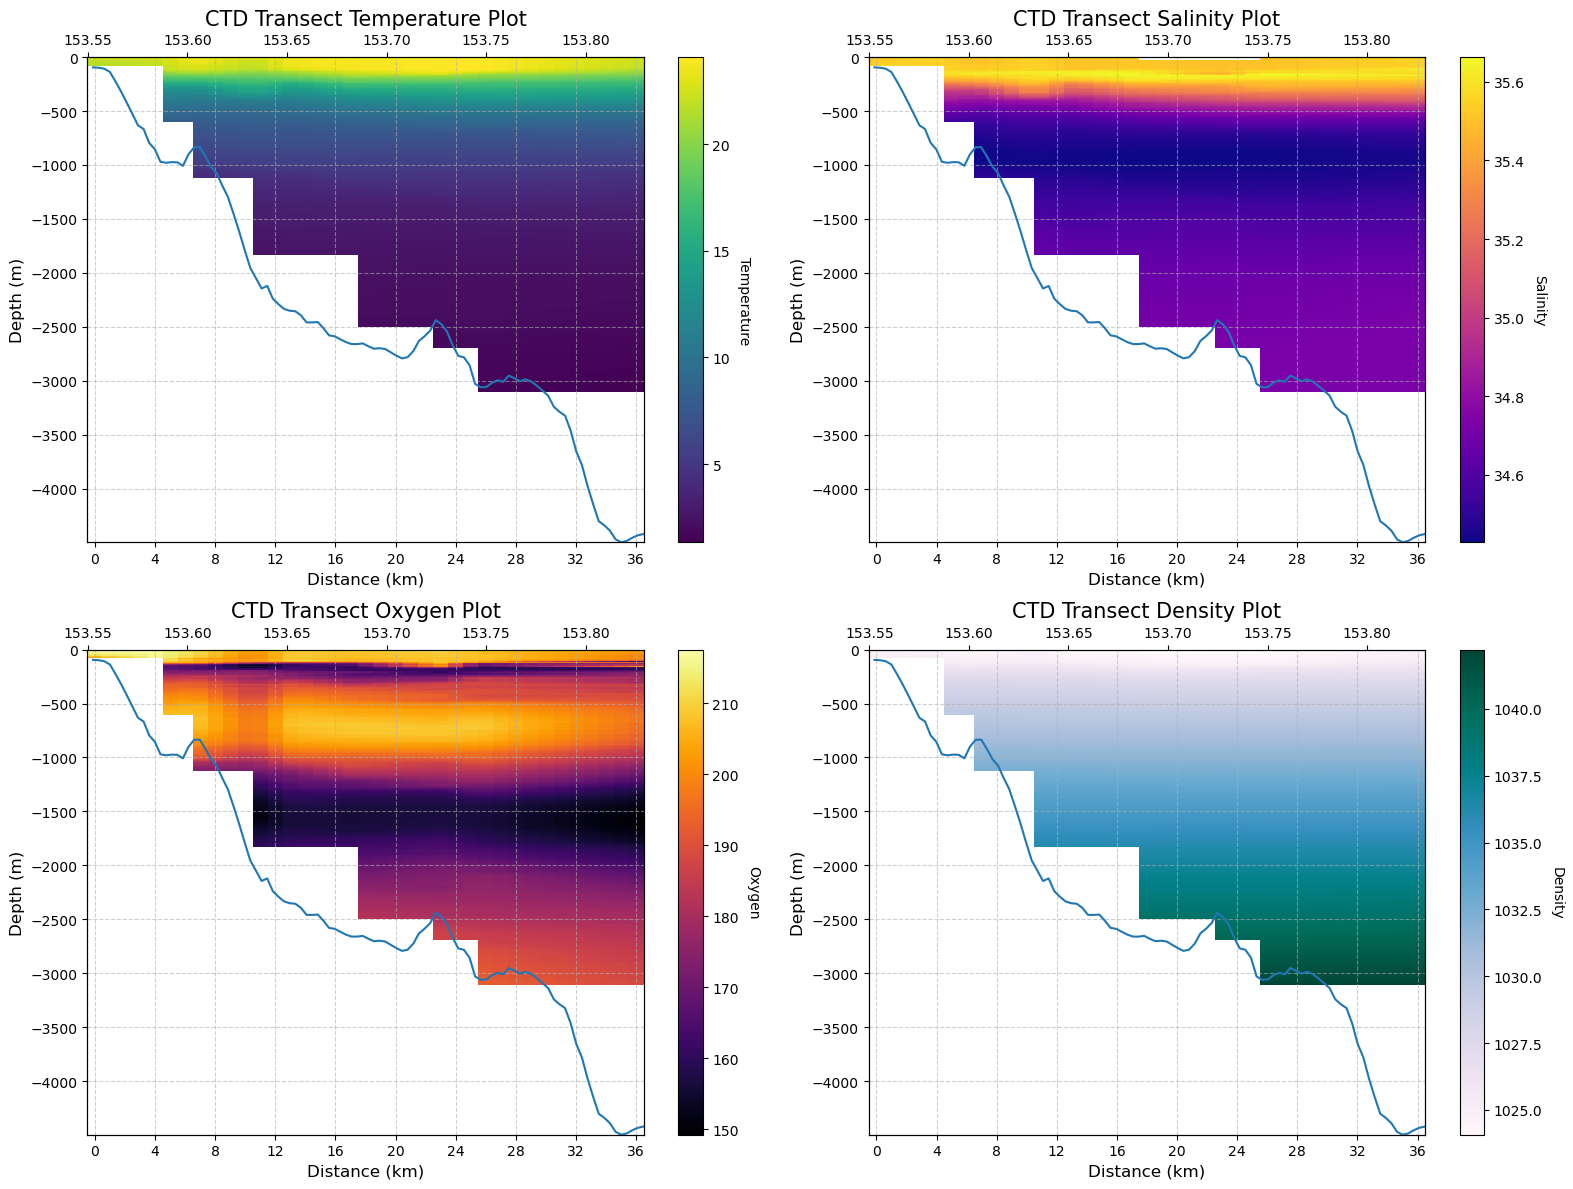

In [18]:
# thalweg transects
plot_interp_profiles(thalweg_sol,dt_thalweg_sol, sol_b)

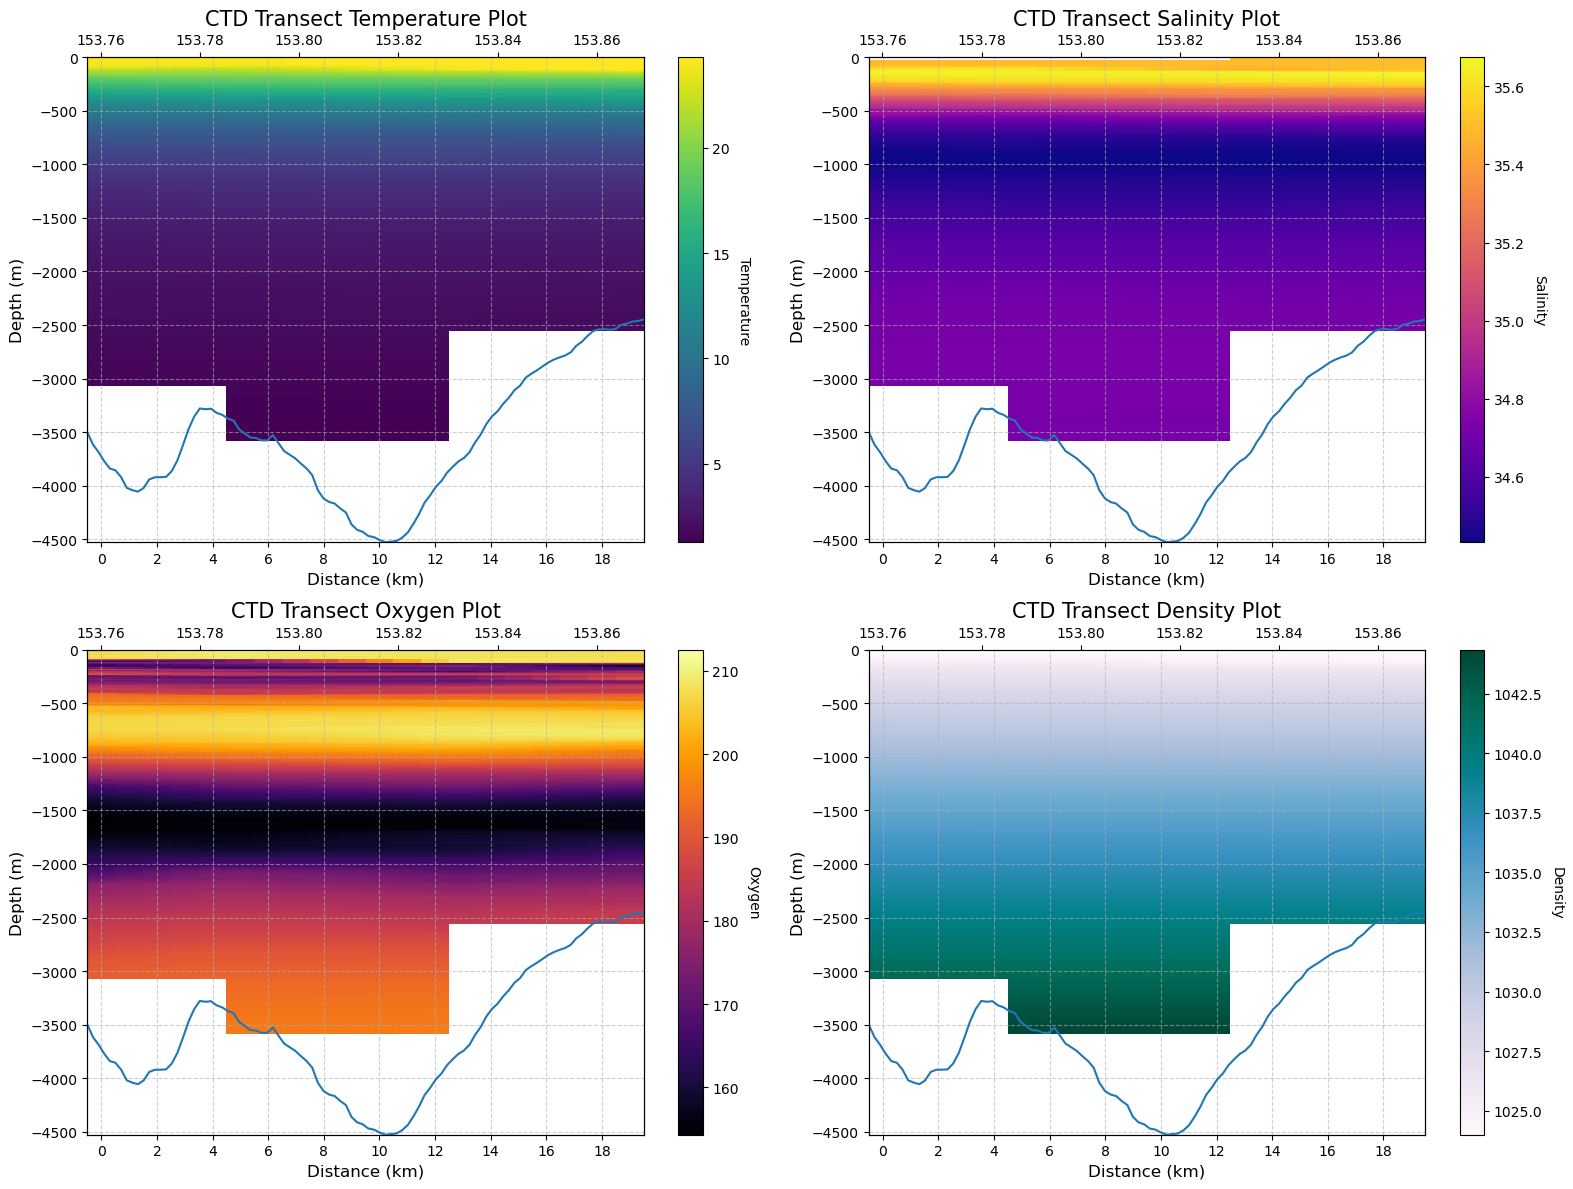

In [19]:
# profiles deepest 
plot_interp_profiles(datasets_transect1,transect1,sol_b)

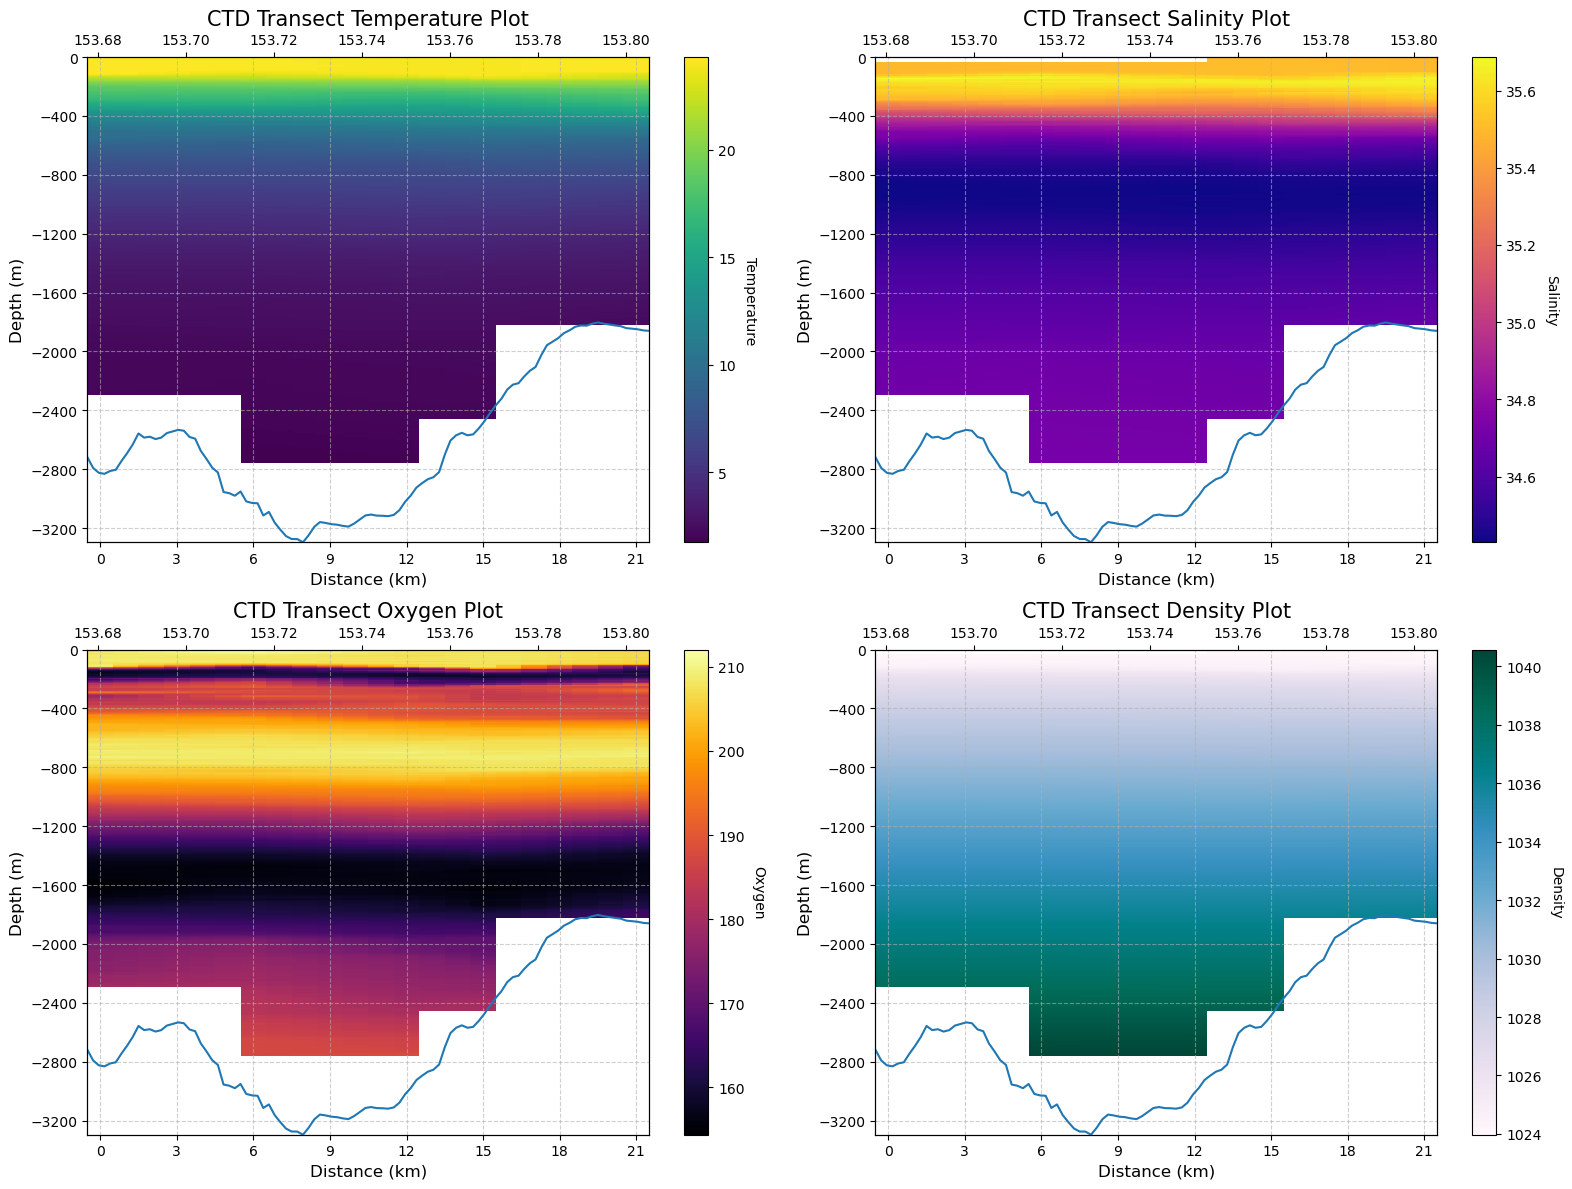

In [20]:
plot_interp_profiles(datasets_transect2,transect2,sol_b)

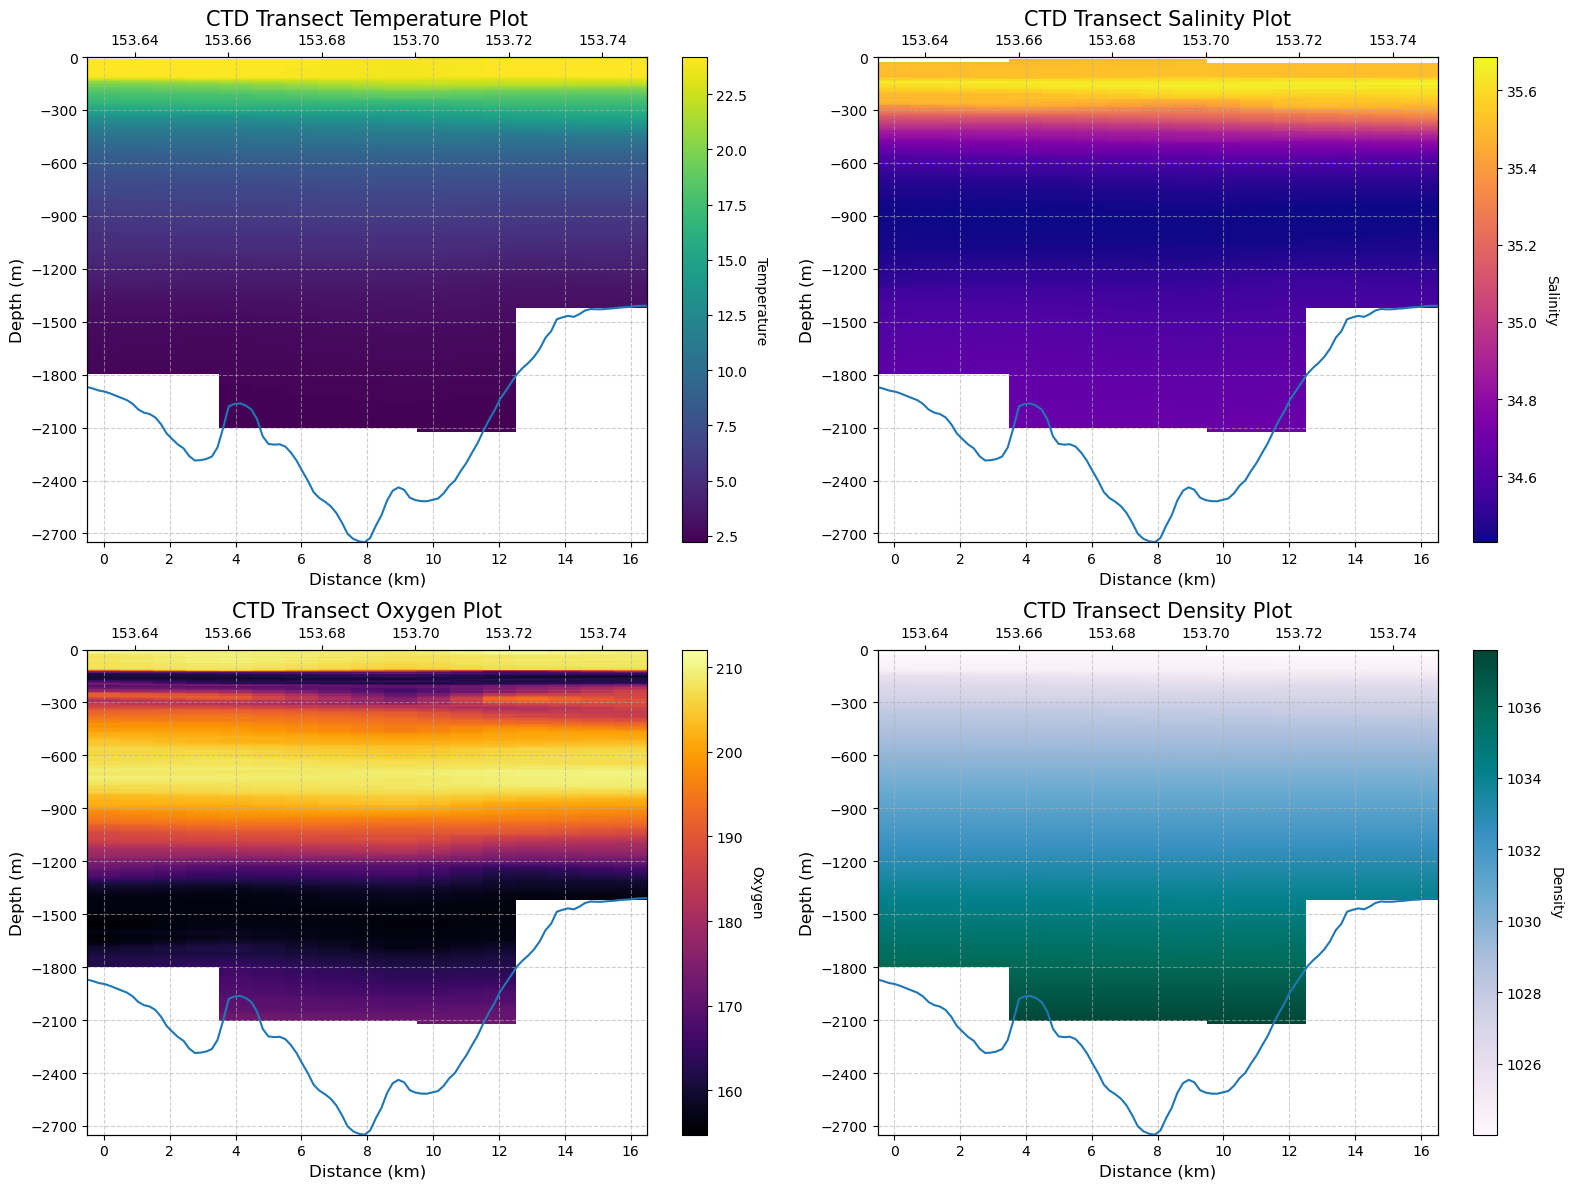

In [21]:
plot_interp_profiles(datasets_transect3,transect3,sol_b)

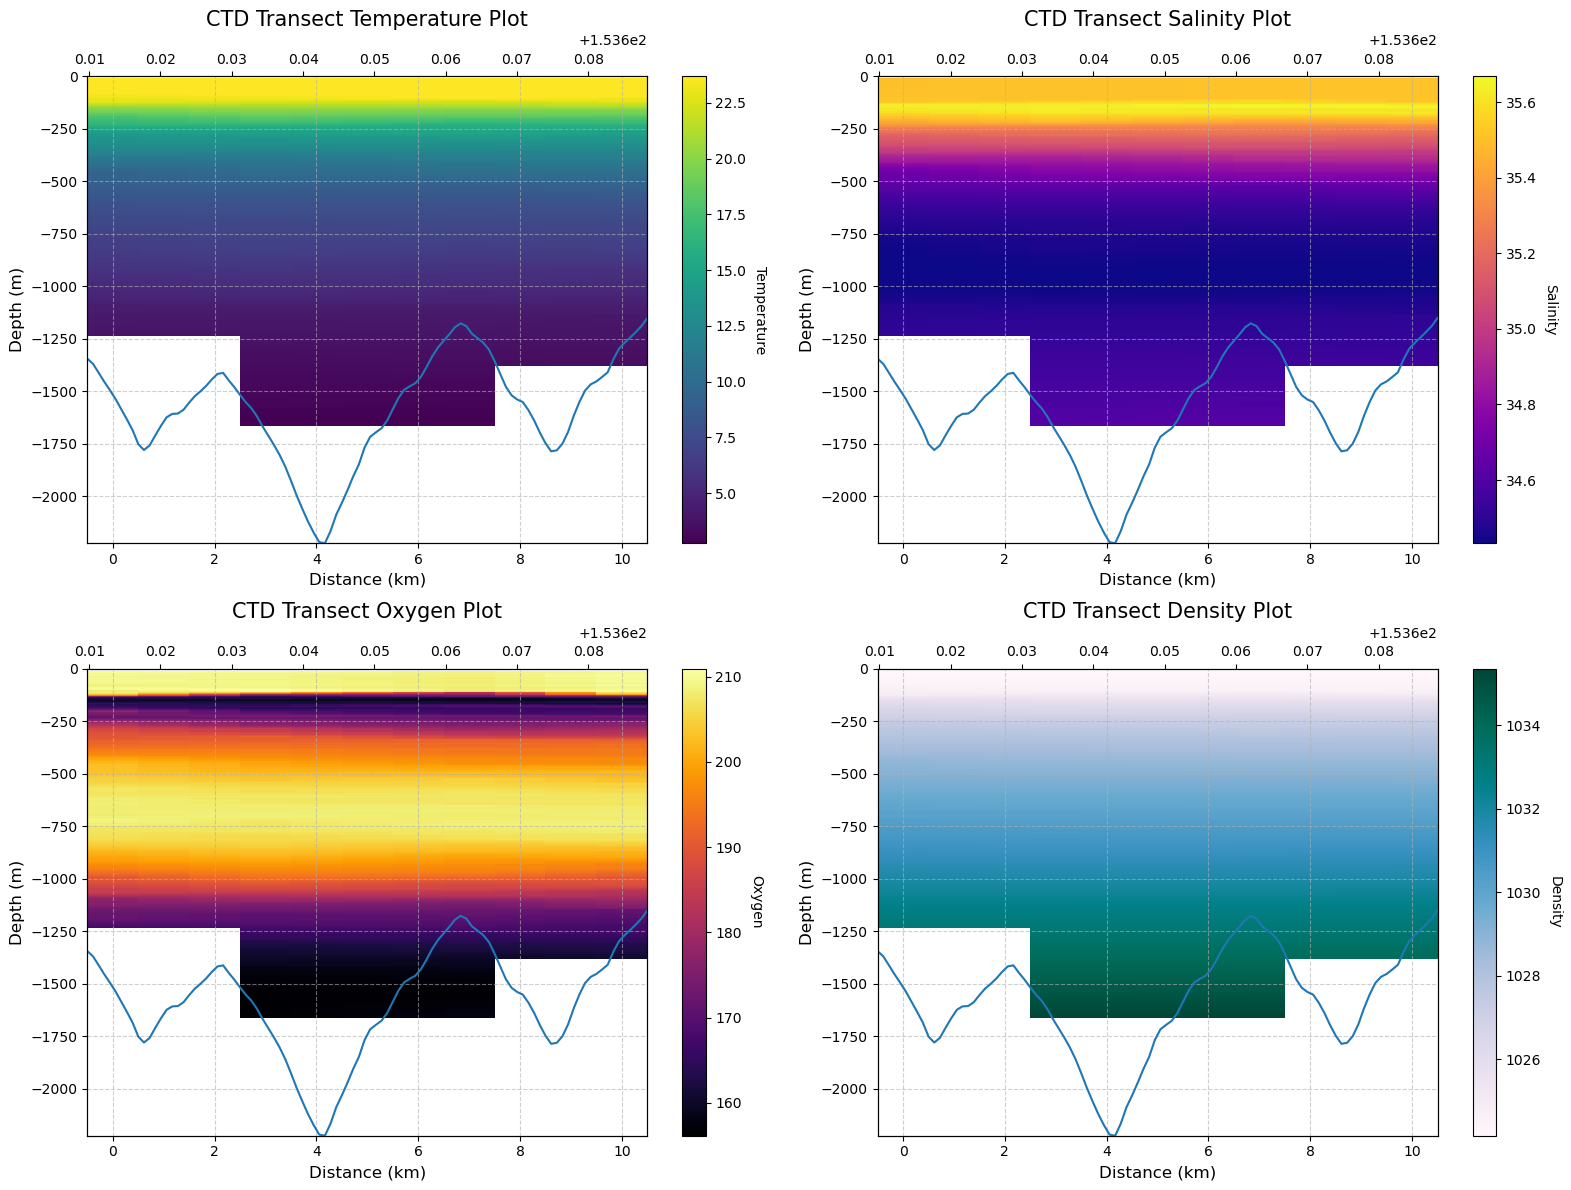

In [22]:
plot_interp_profiles(datasets_transect4,transect4,sol_b)

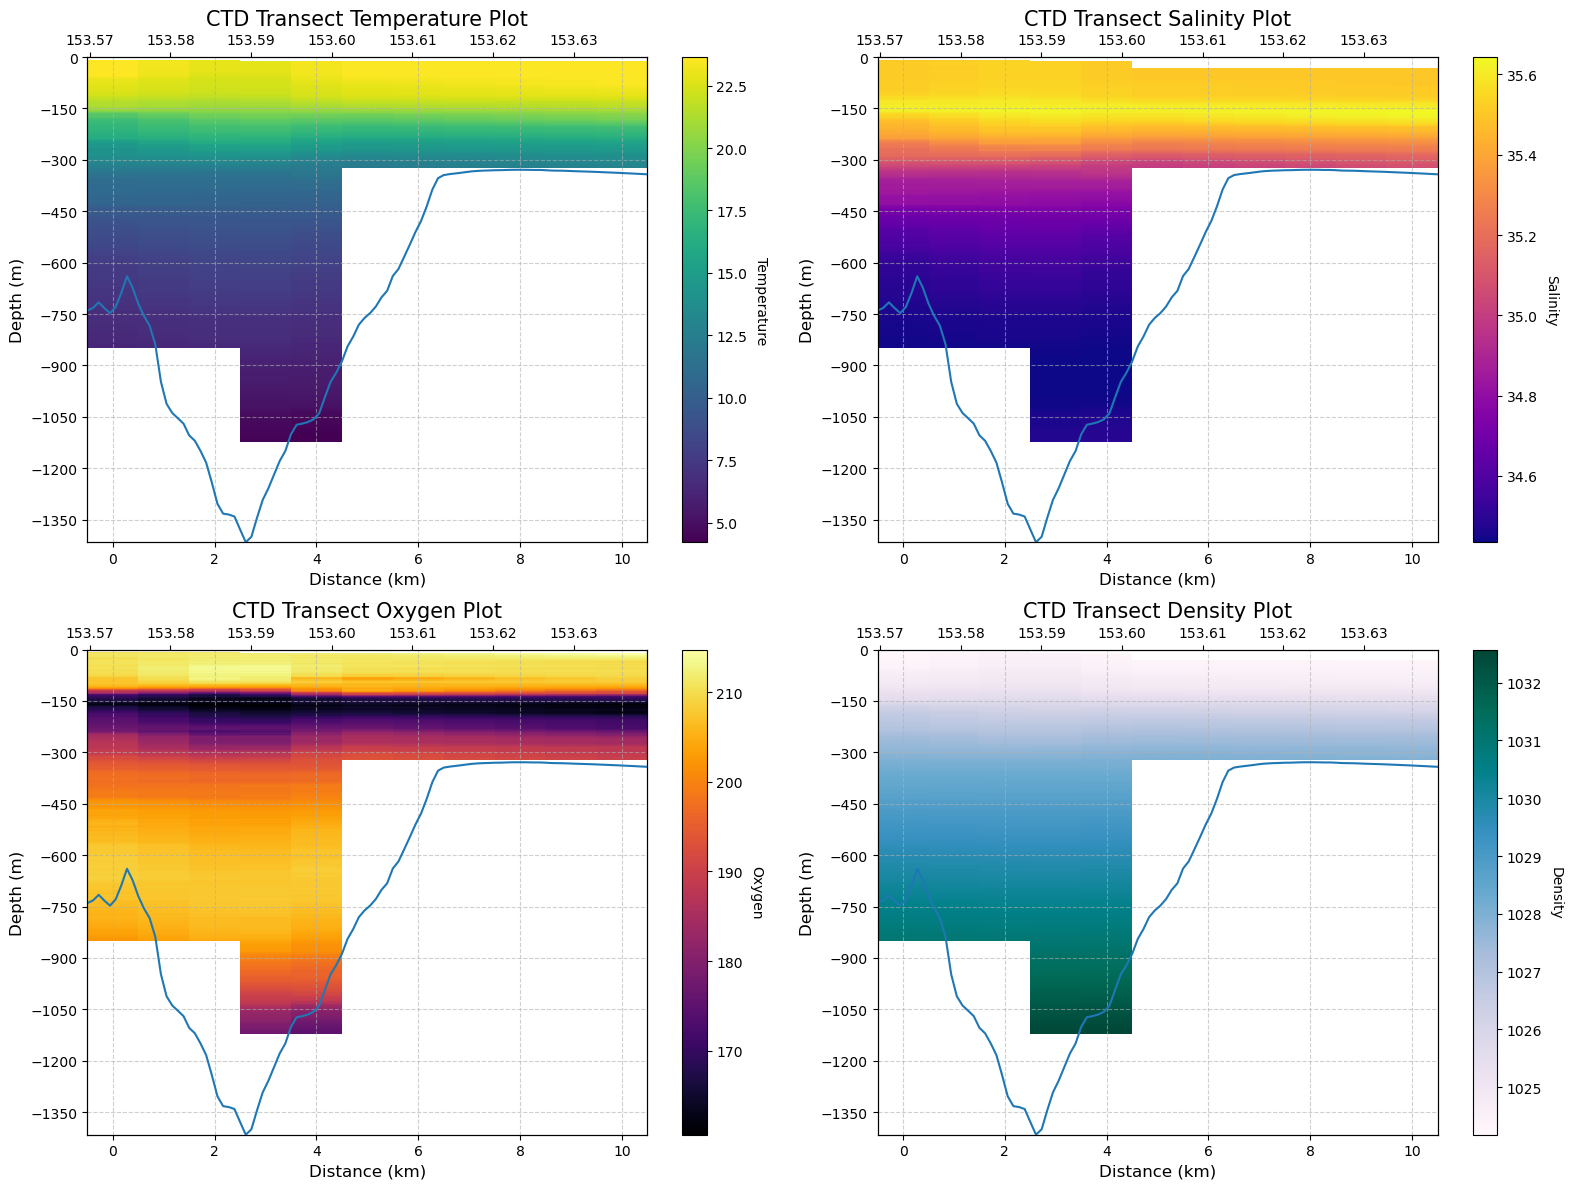

In [23]:
plot_interp_profiles(datasets_transect5,transect5,sol_b)

# Richmond Canyon 



In [24]:
datasets_Rtransect1 = datasets_transects(Rtransect1)
datasets_Rtransect2 = datasets_transects(Rtransect2)
datasets_Rtransect3 = datasets_transects(Rtransect3)
datasets_Rtransect4 = datasets_transects(Rtransect4)


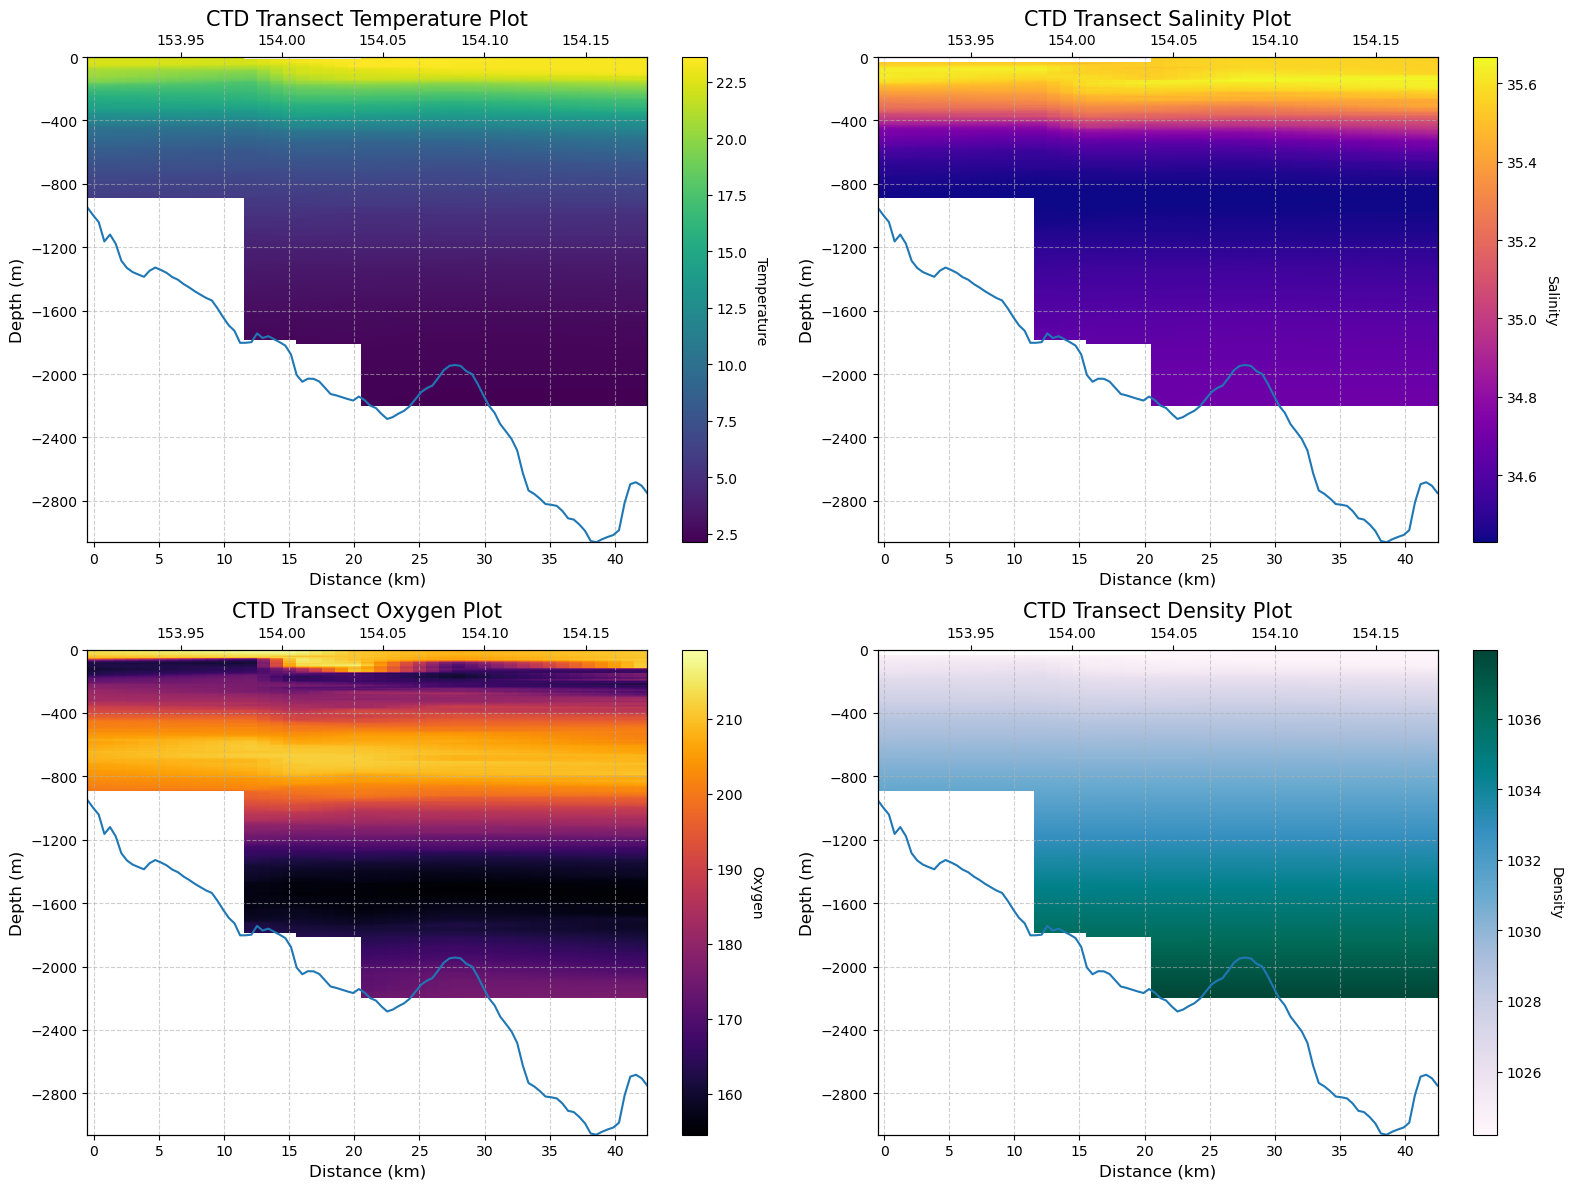

In [25]:
plot_interp_profiles(thalweg_rich,dt_thalweg_rich,rich_b)

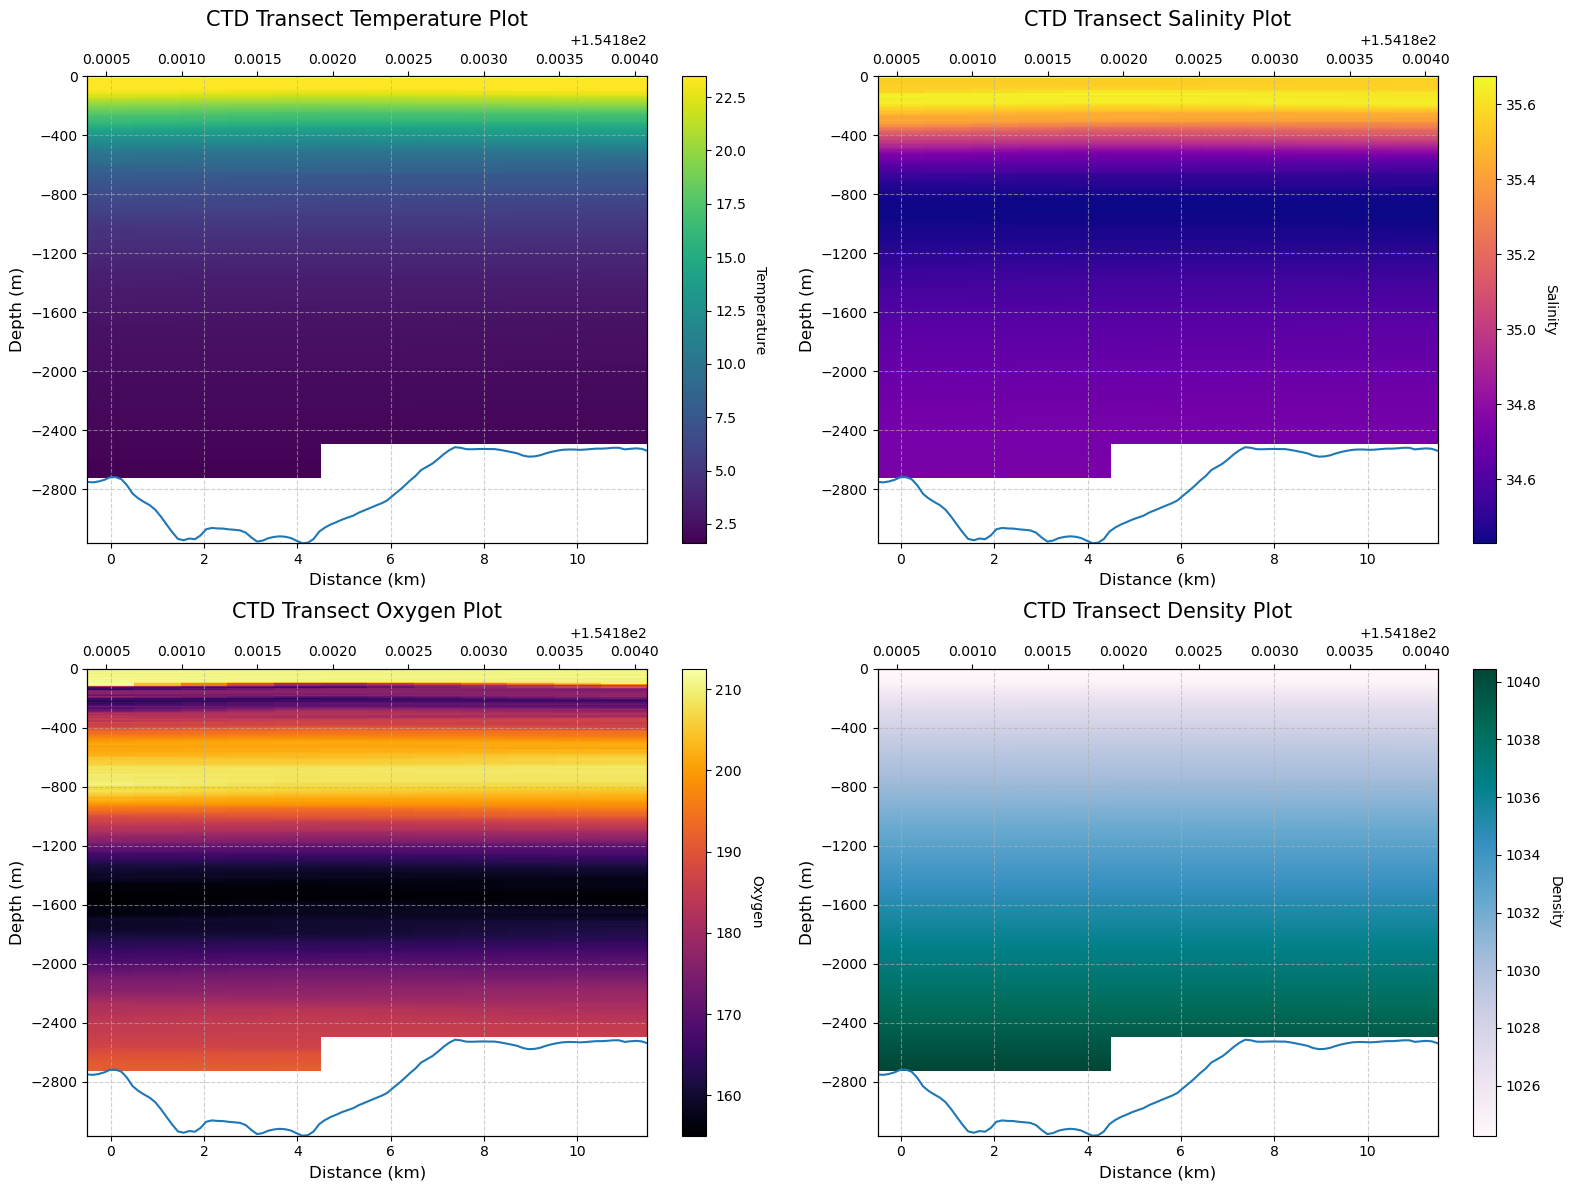

In [26]:
plot_interp_profiles(datasets_Rtransect1,Rtransect1,rich_b)

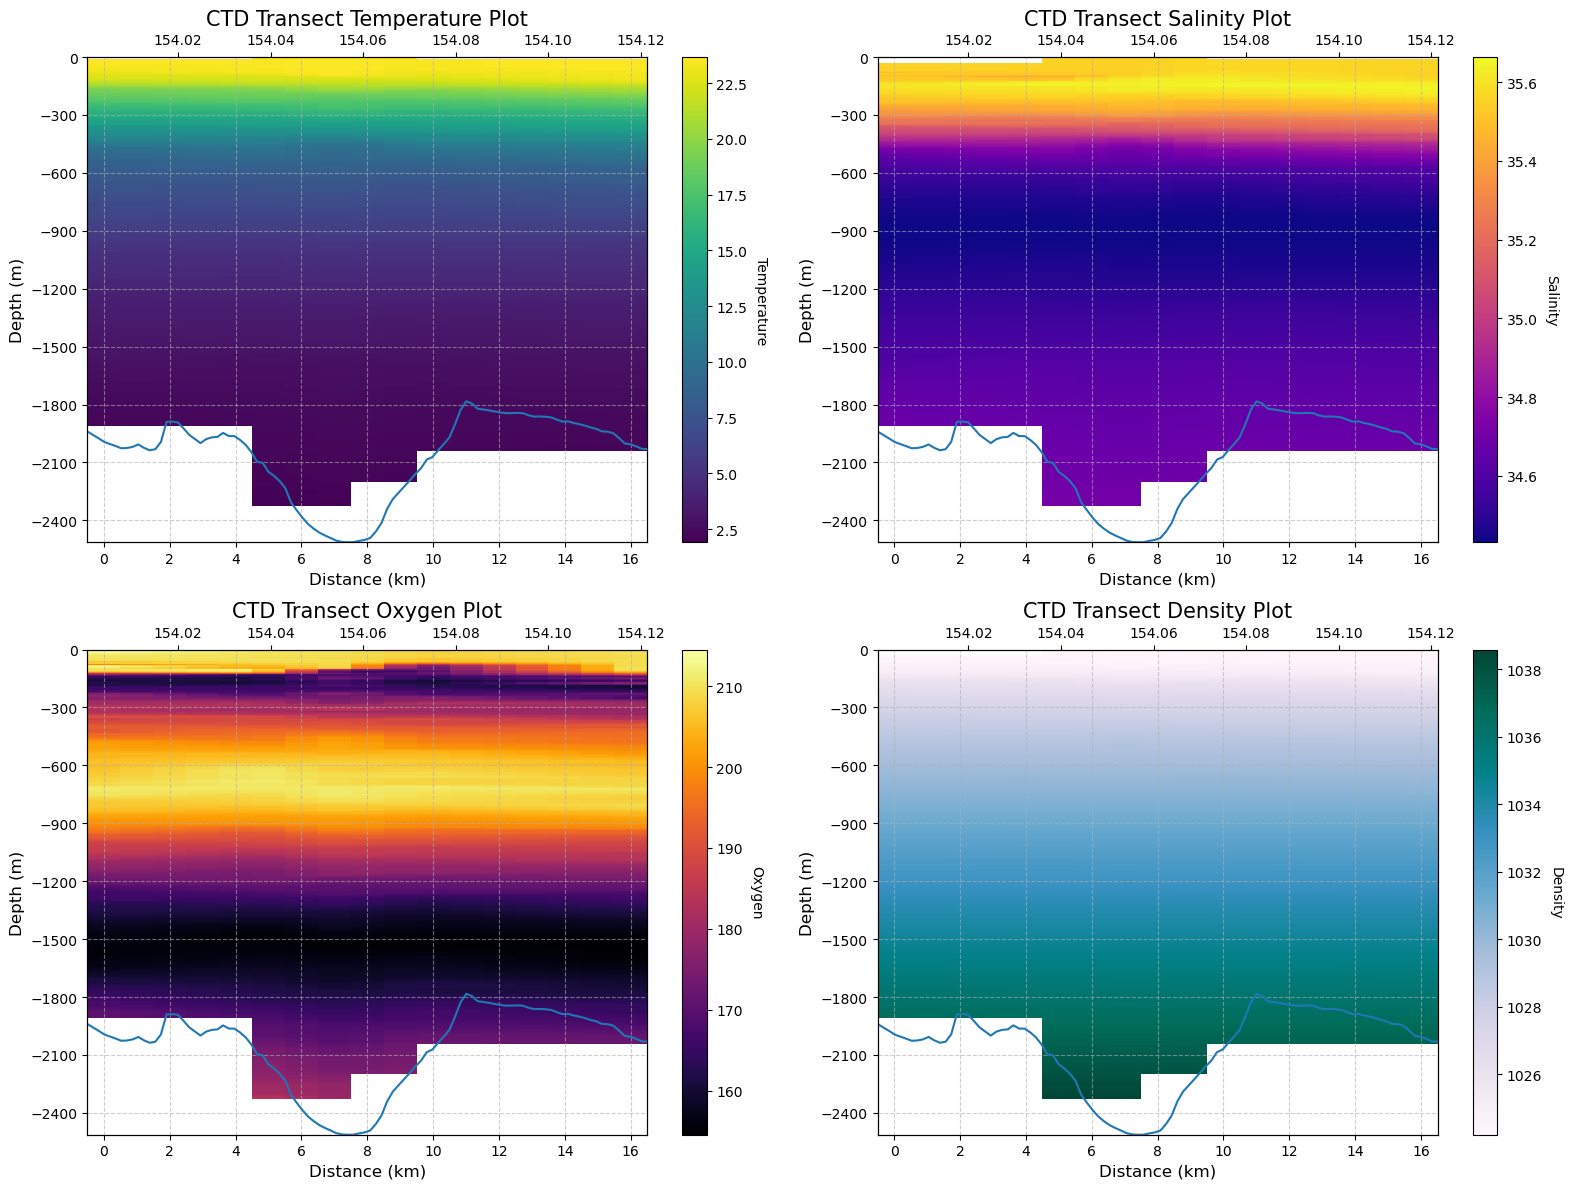

In [27]:
plot_interp_profiles(datasets_Rtransect2,Rtransect2,rich_b)

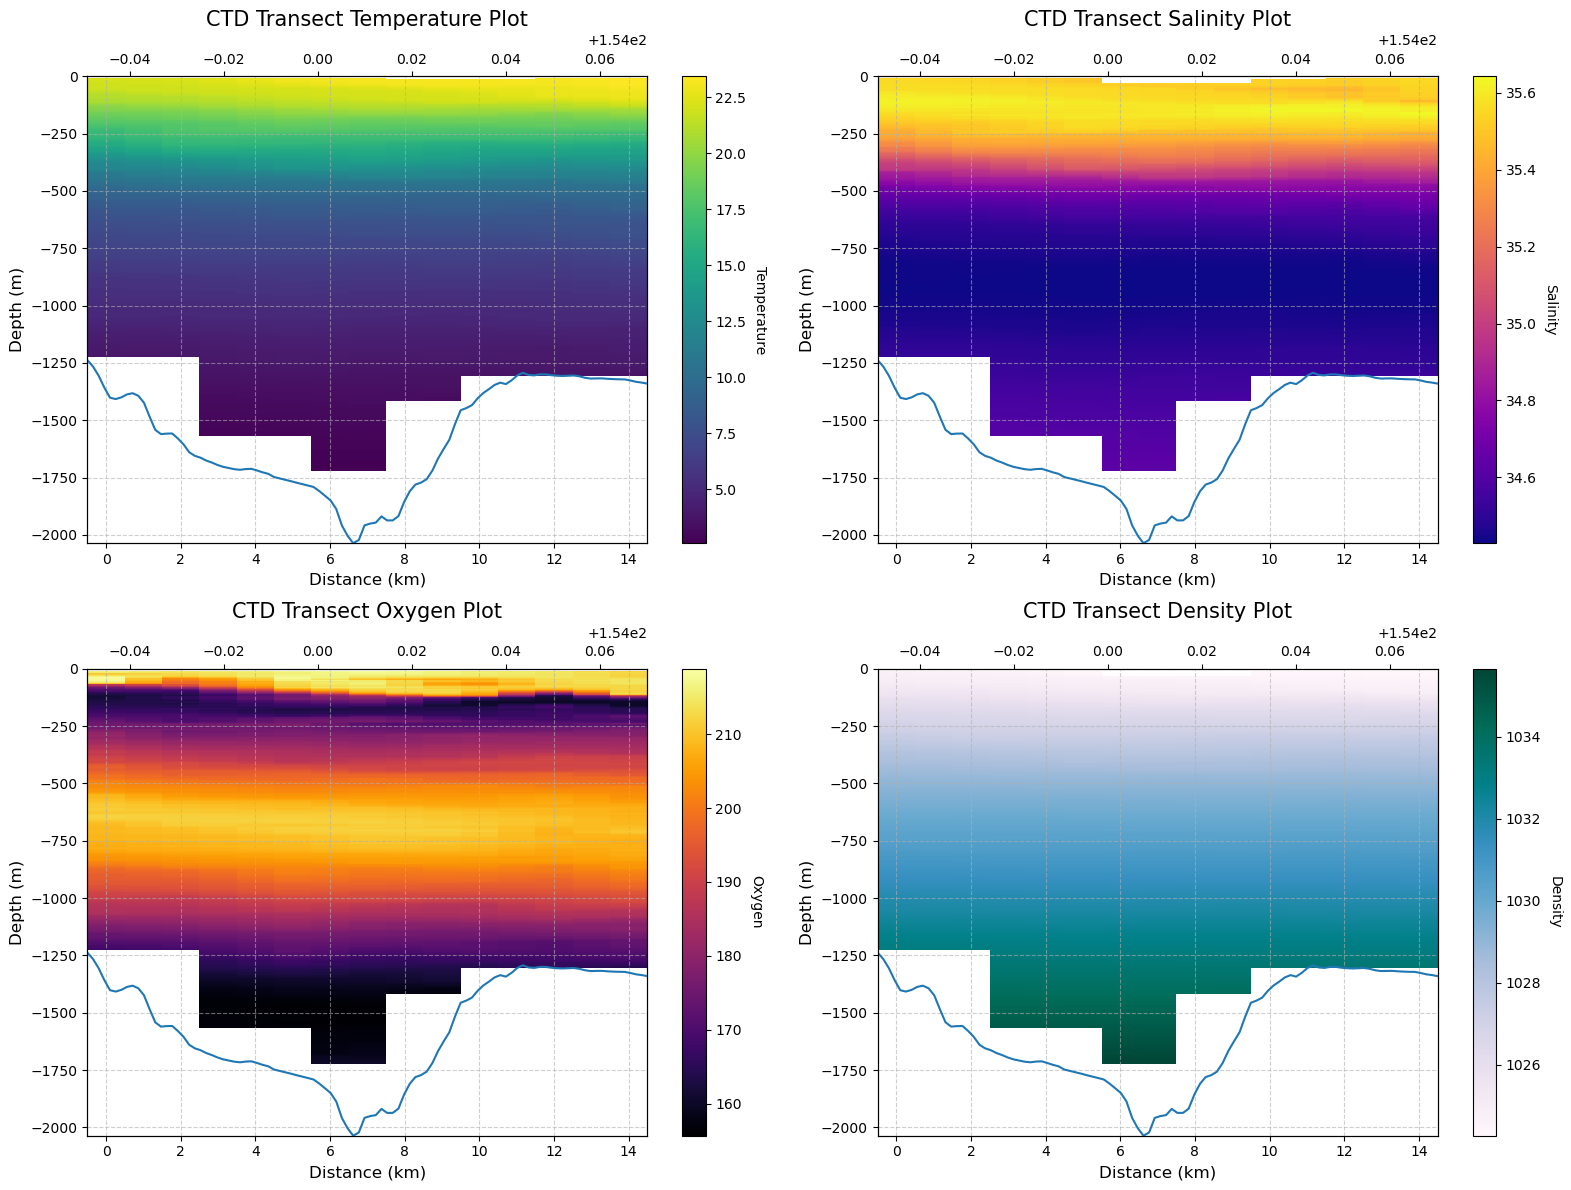

In [28]:
plot_interp_profiles(datasets_Rtransect3,Rtransect3,rich_b)

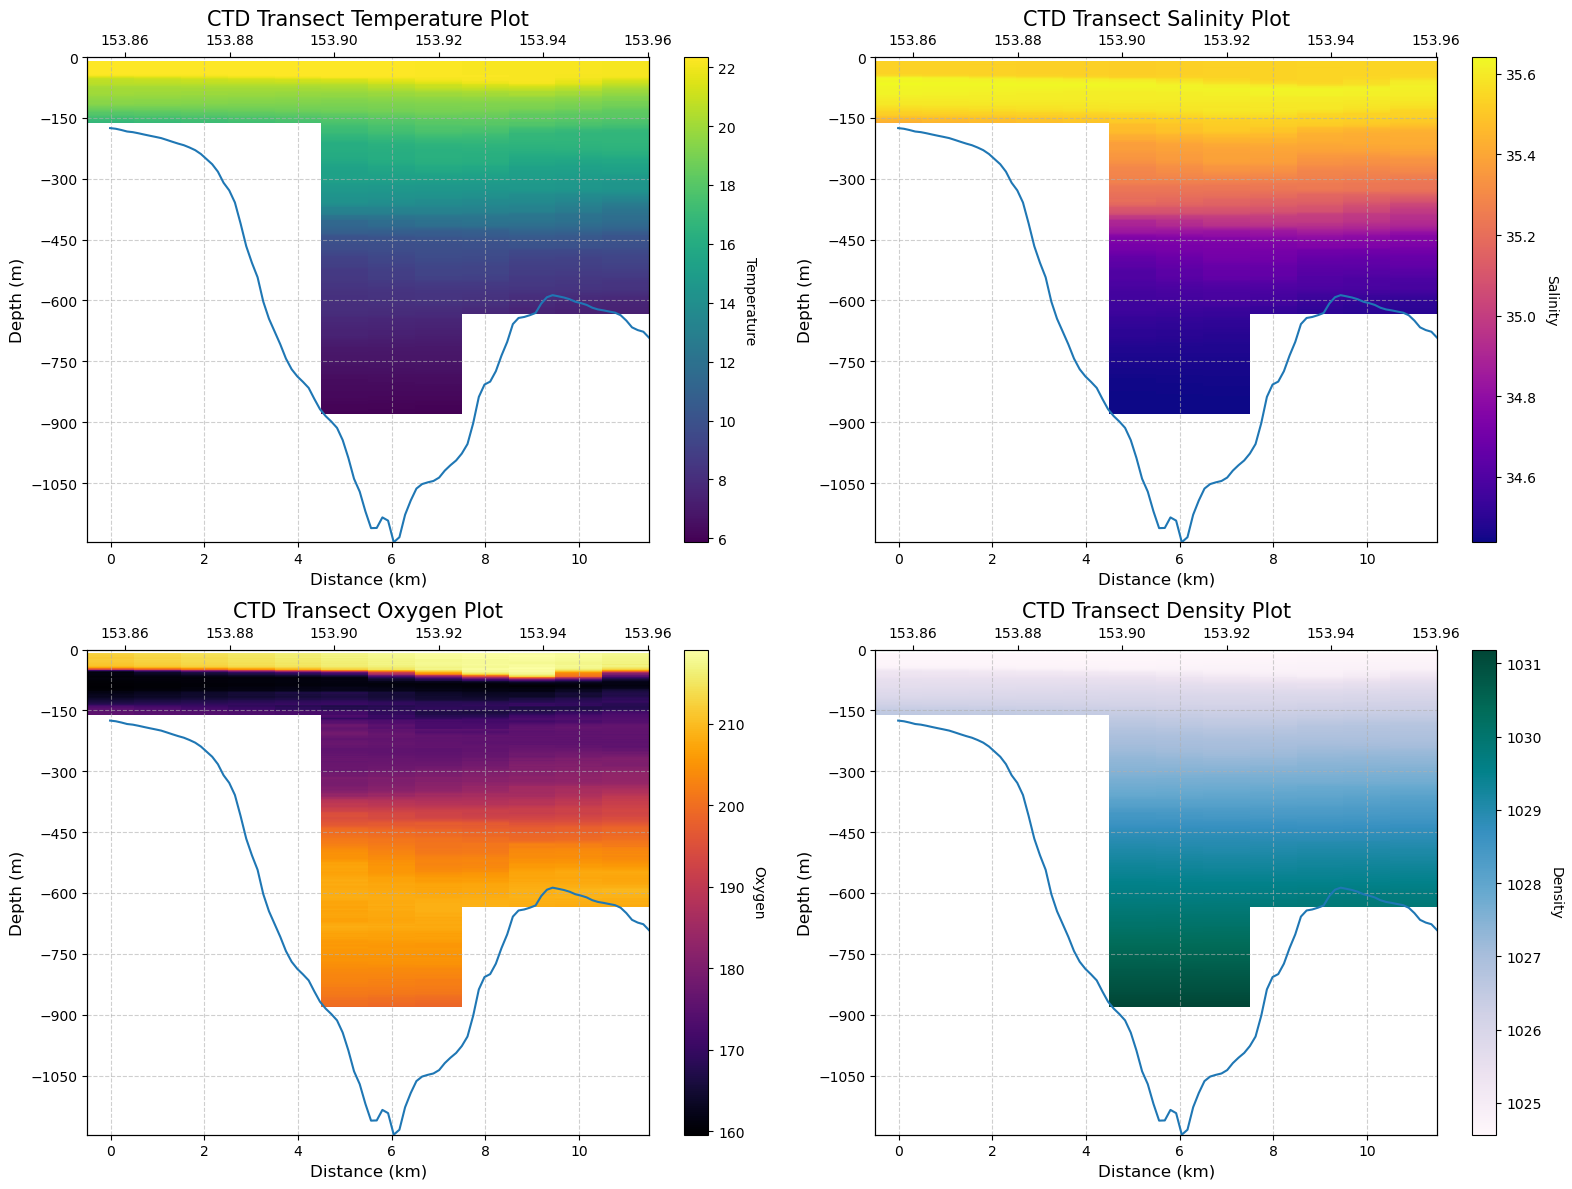

In [29]:
plot_interp_profiles(datasets_Rtransect4,Rtransect4,rich_b)

# Sea Floor oxygen values


In [44]:
# transects for solitarry canyon 
transect1 = [ctd_002, ctd_003, ctd_004, ctd_006]
transect2 = [ctd_007, ctd_013, ctd_016, ctd_015, ctd_014]
transect3 = [ctd_009, ctd_008, ctd_026, ctd_011, ctd_012]
transect4 = [ctd_031,ctd_030, ctd_032, ctd_033]
transect5 = [ctd_027, ctd_076, ctd_029, ctd_028]
transect6 = [ctd_085, ctd_086, ctd_087]

ctds_sol  = [ctd_002, ctd_003, ctd_004, ctd_006, ctd_007, ctd_013, ctd_016, ctd_015, ctd_014, ctd_009, ctd_008, ctd_026, ctd_011, ctd_012, ctd_031,ctd_030, ctd_032, ctd_033, ctd_027, ctd_076, ctd_029, ctd_028, ctd_085, ctd_086, ctd_087]

In [45]:
from scipy.interpolate import griddata


In [46]:
def interp_grid_oxygen(ctds_sol):

    depths_all = []  # Initialize an empty list to store all depths
    oxygen_all = []  # Initialize an empty list to store all oxygen values
    lats_all = []  # Initialize an empty list to store all latitudes
    lons_all = []  # Initialize an empty list to store all longitudes

    for i in range(len(ctds_sol)):
        depths = ctds_sol[i].depth.values
        oxygen = ctds_sol[i].oxygen.values
        lats = [ctds_sol[i].latitude.values[0]]*len(depths)
        lons = [ctds_sol[i].longitude.values[0]]*len(depths)
        depths_all.append(depths)
        oxygen_all.append(np.squeeze(oxygen))
        lats_all.append(lats)  
        lons_all.append(lons)


    depths_all_array = np.concatenate(depths_all)
    oxygen_all_array = np.concatenate(oxygen_all)
    lats_all_array = np.concatenate(lats_all)
    lons_all_array = np.concatenate(lons_all)


    # Define the grid
    lat_grid = np.linspace(min(lats_all_array), max(lats_all_array), 100)  # Adjust the number of points as needed
    lon_grid = np.linspace(min(lons_all_array), max(lons_all_array), 100)  # Adjust the number of points as needed
    depth_grid = np.linspace(min(depths_all_array), max(depths_all_array), 1000)  # Adjust the number of points as needed


    # Create meshgrid
    lon_mesh, lat_mesh, depth_mesh = np.meshgrid( lon_grid,lat_grid, depth_grid)

    # Interpolate oxygen values over the grid
    oxygen_grid = griddata(( lons_all_array,lats_all_array, depths_all_array), oxygen_all_array, (lon_mesh,lat_mesh, depth_mesh), method='linear')
    return oxygen_grid, lon_mesh, lat_mesh, depth_mesh, lon_grid, lat_grid, depth_grid



In [47]:

oxygen_grid, lon_mesh, lat_mesh, depth_mesh, lon_grid, lat_grid, depth_grid = interp_grid_oxygen(ctds_sol)

lowest_oxygen_values = []
lowest_depths = []
grid_lats = []
grid_lons = []

# Iterate over each latitude and longitude point
for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        # Extract the column of depth values at this latitude and longitude
        depth_column = oxygen_grid[i, j, :]

        # Find the lowest depth with a non-NaN value
        for k in range(len(depth_column)):
            if not np.isnan(depth_column[k]):
                lowest_oxygen_values.append(depth_column[k])
                lowest_depths.append(depth_grid[k])
                grid_lats.append(lat_grid[i])
                grid_lons.append(lon_grid[j])
                break  # Stop after finding the first non-NaN value

# Convert lists to arrays for further processing if needed
lowest_oxygen_values = np.array(lowest_oxygen_values)
lowest_depths = np.array(lowest_depths)
grid_lats = np.array(grid_lats)
grid_lons = np.array(grid_lons)



KeyboardInterrupt: 

In [37]:
# Replace this with the path to your CSV file
file_path = '/Users/isabelaconde/Desktop/DTC_data_hab_sol.csv'

# Load the CSV file
df = pd.read_csv(file_path)

# Convert the columns to numpy arrays
habitat_lon = np.array(df.iloc[:, 0].values)
habitat_lat = np.array(df.iloc[:, 1].values)

In [38]:
# adjust colour palette
import matplotlib.colors as mcolors

# Get the original inferno colormap
cmap_inferno = plt.cm.inferno

# # Function to desaturate colors
# def desaturate_colormap(cmap, saturation=0.8):
#     colors = cmap(np.arange(cmap.N))
#     # Convert colors to HLS
#     hls = mcolors.rgb_to_hsv(colors[:, :3])
#     # Decrease saturation
#     hls[:, 1] *= saturation
#     # Convert back to RGB
#     desaturated_colors = mcolors.hsv_to_rgb(hls)
#     return mcolors.ListedColormap(desaturated_colors)

# # Create a desaturated colormap
# desaturated_inferno = desaturate_colormap(cmap_inferno, saturation=0.5)

def adjust_brightness(cmap, factor=0.8):
    colors = cmap(np.arange(cmap.N))
    # Increase brightness
    brighter_colors = np.clip(colors * factor, 0, 1)
    return mcolors.ListedColormap(brighter_colors)

# Create a brighter colormap
brighter_inferno = adjust_brightness(cmap_inferno, factor=0.86)


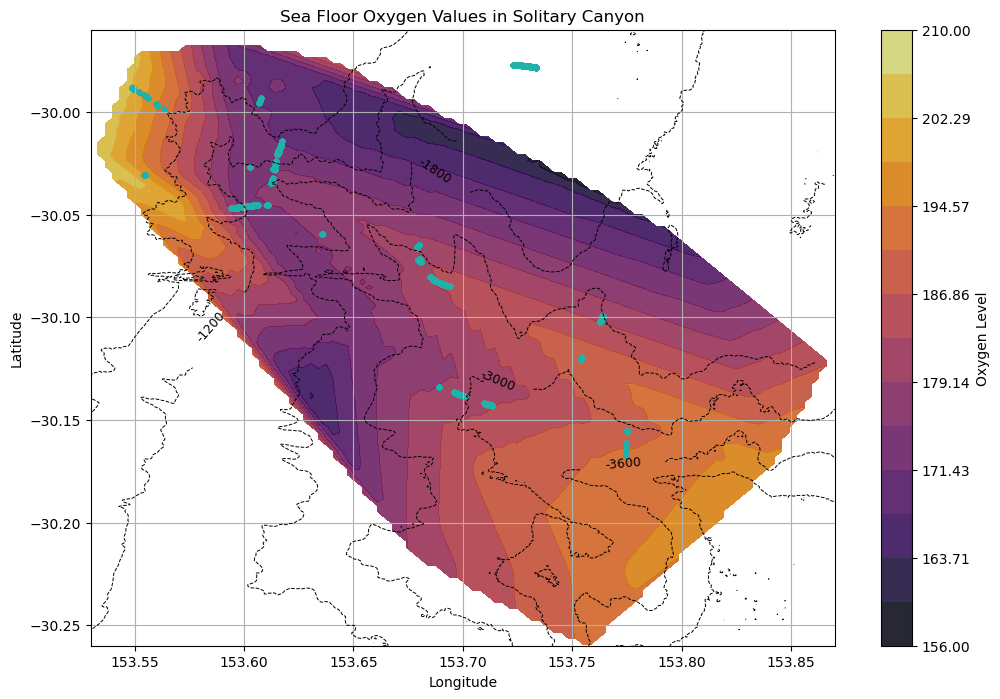

In [39]:
bathy = sol_b
# Load bathymetry data
bathy_data = bathy.Band1
# Create a meshgrid for the contour plot
lon_bathy, lat_bathy = np.meshgrid(bathy.lon, bathy.lat)

# Create a regular grid to interpolate data
lon_grid = np.linspace(min(grid_lons), max(grid_lons), 100)
lat_grid = np.linspace(min(grid_lats), max(grid_lats), 100)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

# Interpolate data onto the regular grid
oxygen_grid = griddata(
    (grid_lons, grid_lats), 
    lowest_oxygen_values, 
    (lon_mesh, lat_mesh), 
    method='linear'
)

# Create the contour plot
plt.figure(figsize=(12, 8))
contour = plt.contourf(lon_mesh, lat_mesh, oxygen_grid,    
    levels=np.linspace(156, 210, 15),  # Ensures levels match vmin and vmax
    cmap=brighter_inferno, 
    vmin=156, 
    vmax=210)# Add bathymetric contours with labels

bathymetric_contours = plt.contour(lon_bathy, lat_bathy, bathy_data, colors='k', linewidths=0.7, zorder=10)
plt.scatter(habitat_lon,habitat_lat, color='lightseagreen', label='Habitat Locations',s=10)
# Add labels to bathymetric contours
plt.clabel(bathymetric_contours, inline=True, fontsize=9, fmt="%.0f", colors='black')


plt.colorbar(contour, label='Oxygen Level')

plt.ylim([-30.26,-29.96])
plt.xlim([153.53,153.87])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sea Floor Oxygen Values in Solitary Canyon')
plt.grid(True)
plt.show()


## Richmond

In [48]:
# transects from richmond canyon
Rtransect1 = [ctd_074,ctd_073,ctd_072]
Rtransect2 = [ctd_066,ctd_065,ctd_069,ctd_064,ctd_063]
Rtransect3 = [ctd_049,ctd_050,ctd_051,ctd_052,ctd_053,ctd_054,ctd_055]
Rtransect4 = [ctd_034,ctd_035,ctd_036,ctd_037,ctd_038]

ctds_rich = [ctd_074,ctd_073,ctd_072,ctd_066,ctd_065,ctd_069,ctd_064,ctd_063,ctd_049,ctd_050,ctd_051,ctd_052,ctd_053,ctd_054,ctd_055,ctd_034,ctd_035,ctd_036,ctd_037,ctd_038]

In [49]:
# richmond computations
oxygen_grid, lon_mesh, lat_mesh, depth_mesh, lon_grid, lat_grid, depth_grid = interp_grid_oxygen(ctds_rich)

lowest_oxygen_values = []
lowest_depths = []
grid_lats = []
grid_lons = []

# Iterate over each latitude and longitude point
for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        # Extract the column of depth values at this latitude and longitude
        depth_column = oxygen_grid[i, j, :]

        # Find the lowest depth with a non-NaN value
        for k in range(len(depth_column)):
            if not np.isnan(depth_column[k]):
                lowest_oxygen_values.append(depth_column[k])
                lowest_depths.append(depth_grid[k])
                grid_lats.append(lat_grid[i])
                grid_lons.append(lon_grid[j])
                break  # Stop after finding the first non-NaN value

# Convert lists to arrays for further processing if needed
lowest_oxygen_values = np.array(lowest_oxygen_values)
lowest_depths = np.array(lowest_depths)
grid_lats = np.array(grid_lats)
grid_lons = np.array(grid_lons)

In [50]:
# Replace this with the path to your CSV file
file_path = '/Users/isabelaconde/Desktop/DTC_data_hab_rich.csv'

# Load the CSV file
df = pd.read_csv(file_path)

# Convert the columns to numpy arrays
habitat_lon = np.array(df.iloc[:, 0].values)
habitat_lat = np.array(df.iloc[:, 1].values)

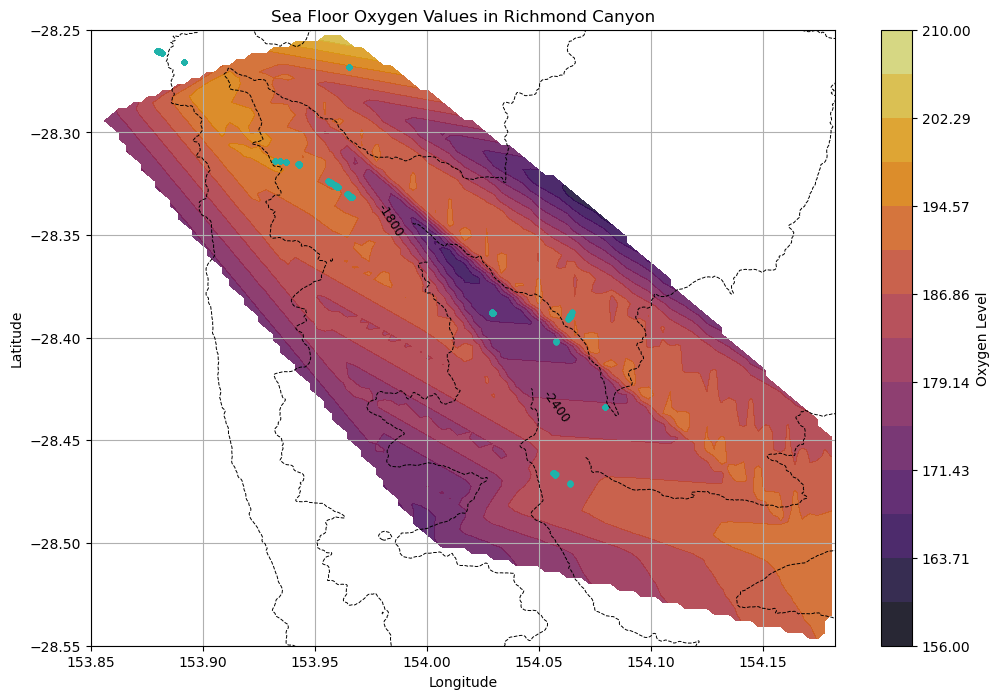

In [52]:
bathy = rich_b
# Load bathymetry data
bathy_data = bathy.Band1
# Create a meshgrid for the contour plot
lon_bathy, lat_bathy = np.meshgrid(bathy.lon, bathy.lat)

# Create a regular grid to interpolate data
lon_grid = np.linspace(min(grid_lons), max(grid_lons), 100)
lat_grid = np.linspace(min(grid_lats), max(grid_lats), 100)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

# Interpolate data onto the regular grid
oxygen_grid = griddata(
    (grid_lons, grid_lats), 
    lowest_oxygen_values, 
    (lon_mesh, lat_mesh), 
    method='linear'
)

# Create the contour plot
fig, ax = plt.subplots(figsize=(12, 8))
contour = plt.contourf(lon_mesh, lat_mesh, oxygen_grid,    
    levels=np.linspace(156, 210, 15),  # Ensures levels match vmin and vmax
    cmap=brighter_inferno, 
    vmin=156, 
    vmax=210)

# Add colorbar with vmin and vmax
# Add bathymetric contours with labels
bathymetric_contours = plt.contour(lon_bathy, lat_bathy, bathy_data, colors='k', linewidths=0.7, zorder=50)
plt.scatter(habitat_lon,habitat_lat, color='lightseagreen', label='Habitat Locations',s=10)
# Add labels to bathymetric contours
plt.clabel(bathymetric_contours, inline=True, fontsize=9, fmt="%.0f", colors='black')


plt.colorbar(contour, label='Oxygen Level')

plt.ylim([-28.55,-28.25])
plt.xlim([153.85,154.182])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sea Floor Oxygen Values in Richmond Canyon')
plt.grid(True)
plt.show()
